# AfriTalent Hub: Identifying Potential Young Talents in East Africa

This notebook analyzes demographic, educational, and socioeconomic factors to identify potential young talents in East Africa who have digital access (cellphones) - a key requirement for showcasing their talents (music, arts, etc.) on our online platform and connecting them with potential sponsors.

## Project Overview

The primary goal is to compare traditional machine learning algorithms with deep learning techniques for identifying digitally-ready young individuals who could showcase their artistic talents on our platform and connect with sponsors.

### Social Impact

Identifying digitally-ready young individuals helps our platform connect talented youth with sponsors who can nurture their artistic development, leading to economic opportunities, cultural preservation, and global recognition for African creative talents.

In [11]:
"""
EAST AFRICA DIGITAL READINESS PREDICTION: ML vs DEEP LEARNING COMPARISON
==========================================================================

Problem Statement:
Predicting digital readiness among East African populations is crucial for:
- Targeted digital literacy programs
- Financial inclusion initiatives
- Mobile banking expansion strategies
- Educational technology deployment
- Government digital services accessibility
- Bridging the digital divide

This project analyzes demographic, educational, and socioeconomic factors to predict
whether individuals have access to cellphones - a key indicator of digital readiness
and economic participation in modern East African societies.

Social Impact:
Understanding digital readiness patterns helps policymakers and NGOs design effective
interventions to increase technology adoption in underserved communities, promoting
economic development and social inclusion.

Author: Isaac MUGISHA
Date: 13 October 2025
"""

'\nEAST AFRICA DIGITAL READINESS PREDICTION: ML vs DEEP LEARNING COMPARISON\n==========================================================================\n\nProblem Statement:\nPredicting digital readiness among East African populations is crucial for:\n- Targeted digital literacy programs\n- Financial inclusion initiatives\n- Mobile banking expansion strategies\n- Educational technology deployment\n- Government digital services accessibility\n- Bridging the digital divide\n\nThis project analyzes demographic, educational, and socioeconomic factors to predict\nwhether individuals have access to cellphones - a key indicator of digital readiness\nand economic participation in modern East African societies.\n\nSocial Impact:\nUnderstanding digital readiness patterns helps policymakers and NGOs design effective\ninterventions to increase technology adoption in underserved communities, promoting\neconomic development and social inclusion.\n\nAuthor: Isaac MUGISHA\nDate: 13 October 2025\n'

## Setup and Installation

The next cell configures our environment by installing necessary libraries and importing them. The code also sets up utility functions that will be used throughout the notebook for talent identification model evaluation and visualization.

In [12]:
# ============================================================================
# SECTION 1: SETUP AND INSTALLATION
# ============================================================================

# Install required packages
!pip install -q pandas numpy scikit-learn matplotlib seaborn tensorflow xgboost imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import OneHotEncoder
import inspect

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Embedding, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully.")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

experiment_results = []

def plot_confusion_matrix(y_true, y_pred, title, ax):
    """Plots a confusion matrix using seaborn and matplotlib."""
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Phone', 'Has Phone'], yticklabels=['No Phone', 'Has Phone'], ax=ax)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, experiment_num, hyperparams, notes):
    """
    Evaluates a trained model and returns metrics.
    Handles both traditional ML models and Keras models (by checking for .predict_proba).
    """

    # 1. Get predictions and probabilities
    is_dl_model = isinstance(model, (Sequential, Model))

    # Keras models
    if is_dl_model:
        y_train_proba = model.predict(X_train).flatten()
        y_val_proba = model.predict(X_val).flatten()
        y_test_proba = model.predict(X_test).flatten()
    # Traditional ML models
    elif hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else: # Models without proba (e.g., some SVCs)
        y_train_proba = model.predict(X_train)
        y_val_proba = model.predict(X_val)
        y_test_proba = model.predict(X_test)

    # Convert probabilities to binary predictions (0 or 1)
    y_train_pred = (y_train_proba > 0.5).astype(int)
    y_val_pred = (y_val_proba > 0.5).astype(int)
    y_test_pred = (y_test_proba > 0.5).astype(int)

    # 2. Calculate Metrics
    results = {
        'Experiment': experiment_num,
        'Model': model_name,
        'Hyperparams': hyperparams,

        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Train_Precision': precision_score(y_train, y_train_pred, zero_division=0),
        'Train_Recall': recall_score(y_train, y_train_pred, zero_division=0),
        'Train_F1': f1_score(y_train, y_train_pred, zero_division=0),
        'Train_AUC': roc_auc_score(y_train, y_train_proba),

        'Val_Accuracy': accuracy_score(y_val, y_val_pred),
        'Val_Precision': precision_score(y_val, y_val_pred, zero_division=0),
        'Val_Recall': recall_score(y_val, y_val_pred, zero_division=0),
        'Val_F1': f1_score(y_val, y_val_pred, zero_division=0),
        'Val_AUC': roc_auc_score(y_val, y_val_proba),

        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Test_Precision': precision_score(y_test, y_test_pred, zero_division=0),
        'Test_Recall': recall_score(y_test, y_test_pred, zero_division=0),
        'Test_F1': f1_score(y_test, y_test_pred, zero_division=0),
        'Test_AUC': roc_auc_score(y_test, y_test_proba),
        'Notes': notes
    }

    # 3. Print summary
    print(f"\n{'='*70}")
    print(f"EXPERIMENT {experiment_num}: {model_name} RESULTS")
    print(f"{'='*70}")
    print(f"Hyperparameters: {hyperparams}")
    print(f"\n{'Metric':<15} {'Train':<12} {'Validation':<12} {'Test':<12}")
    print(f"{'-'*51}")
    print(f"{'Accuracy':<15} {results['Train_Accuracy']:.4f}     {results['Val_Accuracy']:.4f}     {results['Test_Accuracy']:.4f}")
    print(f"{'Precision':<15} {results['Train_Precision']:.4f}     {results['Val_Precision']:.4f}     {results['Test_Precision']:.4f}")
    print(f"{'Recall':<15} {results['Train_Recall']:.4f}     {results['Val_Recall']:.4f}     {results['Test_Recall']:.4f}")
    print(f"{'F1-Score':<15} {results['Train_F1']:.4f}     {results['Val_F1']:.4f}     {results['Test_F1']:.4f}")
    print(f"{'AUC-ROC':<15} {results['Train_AUC']:.4f}     {results['Val_AUC']:.4f}     {results['Test_AUC']:.4f}")
    print(f"{'-'*51}")

    # 4. Visualize (Confusion Matrix and ROC Curve for Test Set)

    # Confusion Matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    plot_confusion_matrix(y_train, y_train_pred, 'Training Set CM', axes[0])
    plot_confusion_matrix(y_val, y_val_pred, 'Validation Set CM', axes[1])
    plot_confusion_matrix(y_test, y_test_pred, 'Test Set CM', axes[2])

    plt.suptitle(f'Experiment {experiment_num}: {model_name} - Confusion Matrices', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # ROC Curves
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (y_true, y_proba, title) in enumerate([
        (y_train, y_train_proba, 'Training Set'),
        (y_val, y_val_proba, 'Validation Set'),
        (y_test, y_test_proba, 'Test Set')
    ]):
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc = roc_auc_score(y_true, y_proba)

        axes[idx].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc:.4f})')
        axes[idx].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_ylabel('True Positive Rate')
        axes[idx].set_title(f'{title}', fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.suptitle(f'Experiment {experiment_num}: {model_name} - ROC Curves', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    return results

All libraries imported successfully.
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
# ============================================================================
# SECTION 2: DATA LOADING
# ============================================================================

print("\n" + "="*80)
print("SECTION 2: DATA LOADING")
print("="*80)

# Load the dataset
url = "https://raw.githubusercontent.com/Mugisha-isaac/East-Africa-Digital-Readness-prediction/refs/heads/master/data.csv"
df = pd.read_csv(url)

print(f"\nDataset loaded successfully.")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display basic information
print("\nDataset Structure:")
print(df.info())


SECTION 2: DATA LOADING

Dataset loaded successfully.
Shape: 23,524 rows × 13 columns
Memory usage: 2.33 MB

First 5 rows of the dataset:
  country  year    uniqueid bank_account location_type cellphone_access  \
0   Kenya  2018  uniqueid_1          Yes         Rural              Yes   
1   Kenya  2018  uniqueid_2           No         Rural               No   
2   Kenya  2018  uniqueid_3          Yes         Urban              Yes   
3   Kenya  2018  uniqueid_4           No         Rural              Yes   
4   Kenya  2018  uniqueid_5           No         Urban               No   

   household_size  age_of_respondent gender_of_respondent  \
0               3                 24               Female   
1               5                 70               Female   
2               5                 26                 Male   
3               5                 34               Female   
4               8                 26                 Male   

  relationship_with_head           marital_

## Data Loading

In this section, we load the East Africa digital readiness dataset from GitHub. The data contains information about individuals across East African countries, with demographic and socioeconomic variables that might influence digital access and thus their ability to use our talent platform.

The dataset includes a binary target variable `cellphone_access` that indicates whether an individual has access to a cellphone (1) or not (0), which is crucial for determining if they can use our platform to showcase their talents.


SECTION 3: EXPLORATORY DATA ANALYSIS

--- 3.1: Basic Statistics ---
       country        year     uniqueid bank_account location_type  \
count    23524  23524.0000        23524        23524         23524   
unique       4         NaN         8735            2             2   
top     Rwanda         NaN  uniqueid_17           No         Rural   
freq      8735         NaN            4        20212         14343   
mean       NaN   2016.9759          NaN          NaN           NaN   
std        NaN      0.8474          NaN          NaN           NaN   
min        NaN   2016.0000          NaN          NaN           NaN   
25%        NaN   2016.0000          NaN          NaN           NaN   
50%        NaN   2017.0000          NaN          NaN           NaN   
75%        NaN   2018.0000          NaN          NaN           NaN   
max        NaN   2018.0000          NaN          NaN           NaN   

       cellphone_access  household_size  age_of_respondent  \
count             23524     

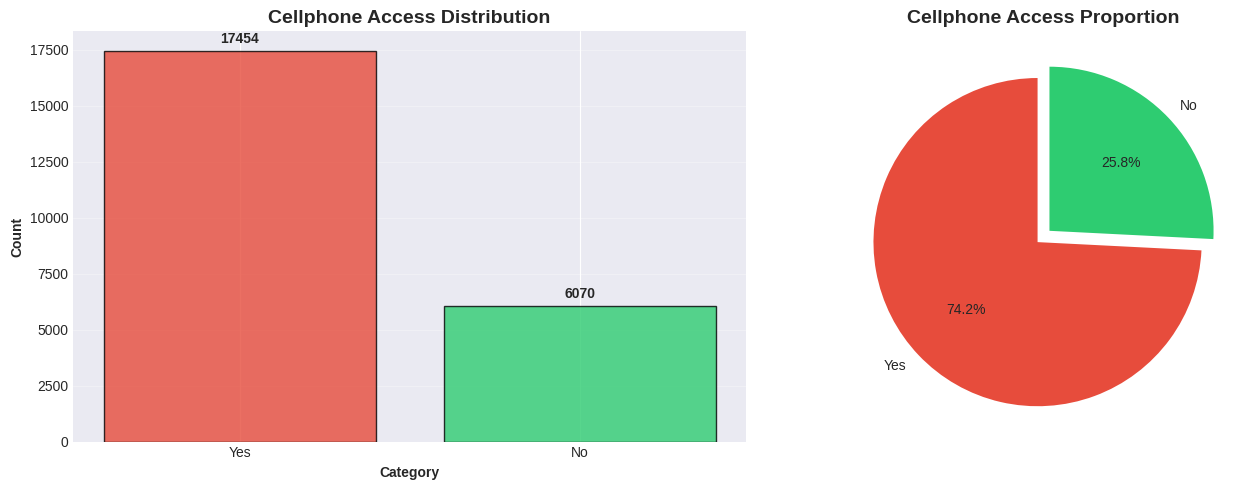

Insight: The target variable shows imbalanced classes.

--- 3.7: Key Categorical Variables ---

bank_account:
bank_account
No     20212
Yes     3312
Name: count, dtype: int64
Total unique values: 2

location_type:
location_type
Rural    14343
Urban     9181
Name: count, dtype: int64
Total unique values: 2

gender_of_respondent:
gender_of_respondent
Female    13877
Male       9647
Name: count, dtype: int64
Total unique values: 2

relationship_with_head:
relationship_with_head
Head of Household    12831
Spouse                6520
Child                 2229
Parent                1086
Other relative         668
Name: count, dtype: int64
Total unique values: 6

marital_status:
marital_status
Married/Living together    10749
Single/Never Married        7983
Widowed                     2708
Divorced/Seperated          2076
Dont know                      8
Name: count, dtype: int64
Total unique values: 5

education_level:
education_level
Primary education                  12791
No formal educa

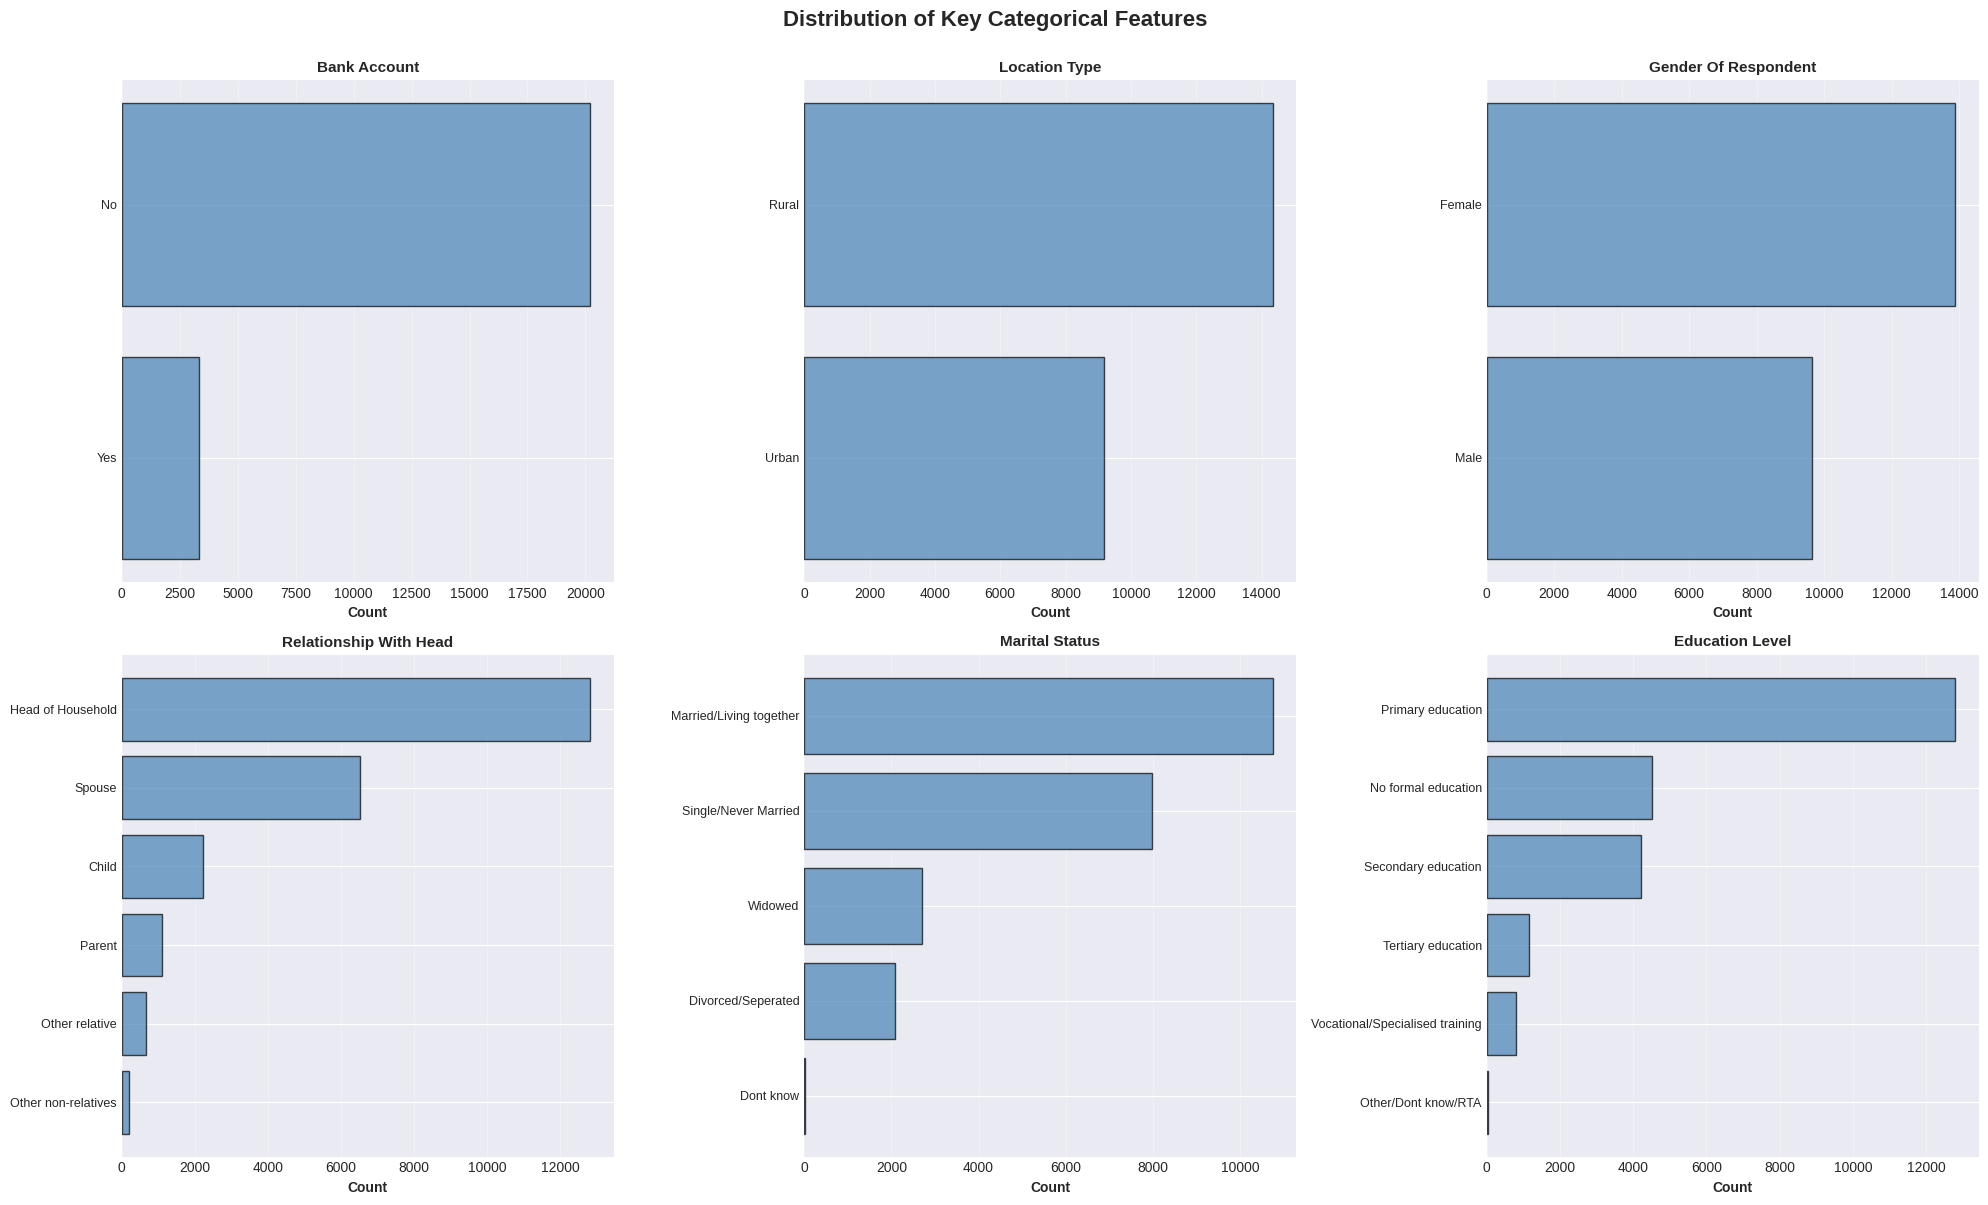


--- 3.9: Numerical Variables Analysis ---
             year  household_size  age_of_respondent
count  23524.0000      23524.0000         23524.0000
mean    2016.9759          3.7975            38.8052
std        0.8474          2.2276            16.5206
min     2016.0000          1.0000            16.0000
25%     2016.0000          2.0000            26.0000
50%     2017.0000          3.0000            35.0000
75%     2018.0000          5.0000            49.0000
max     2018.0000         21.0000           100.0000


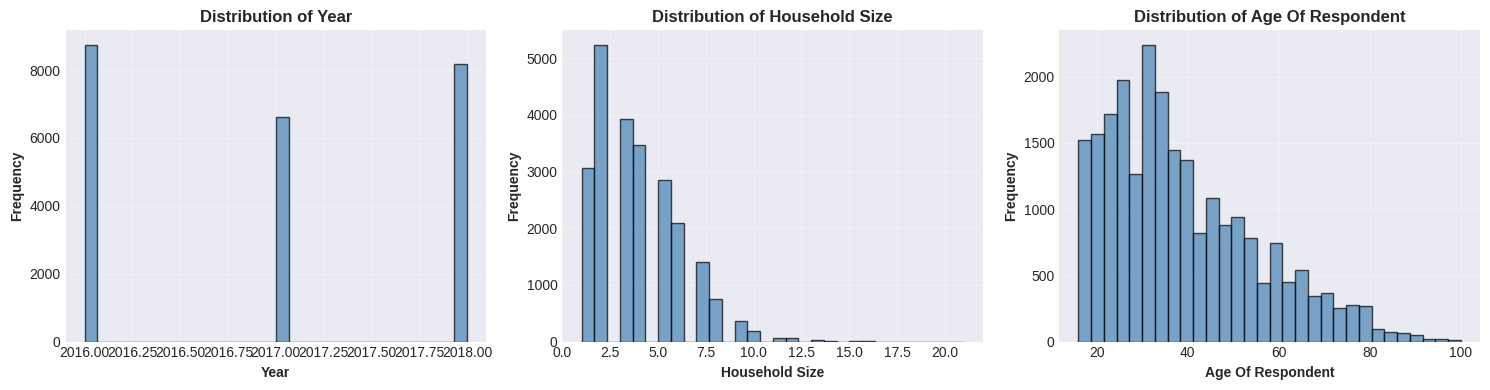


--- 3.10: Feature-Target Relationships ---


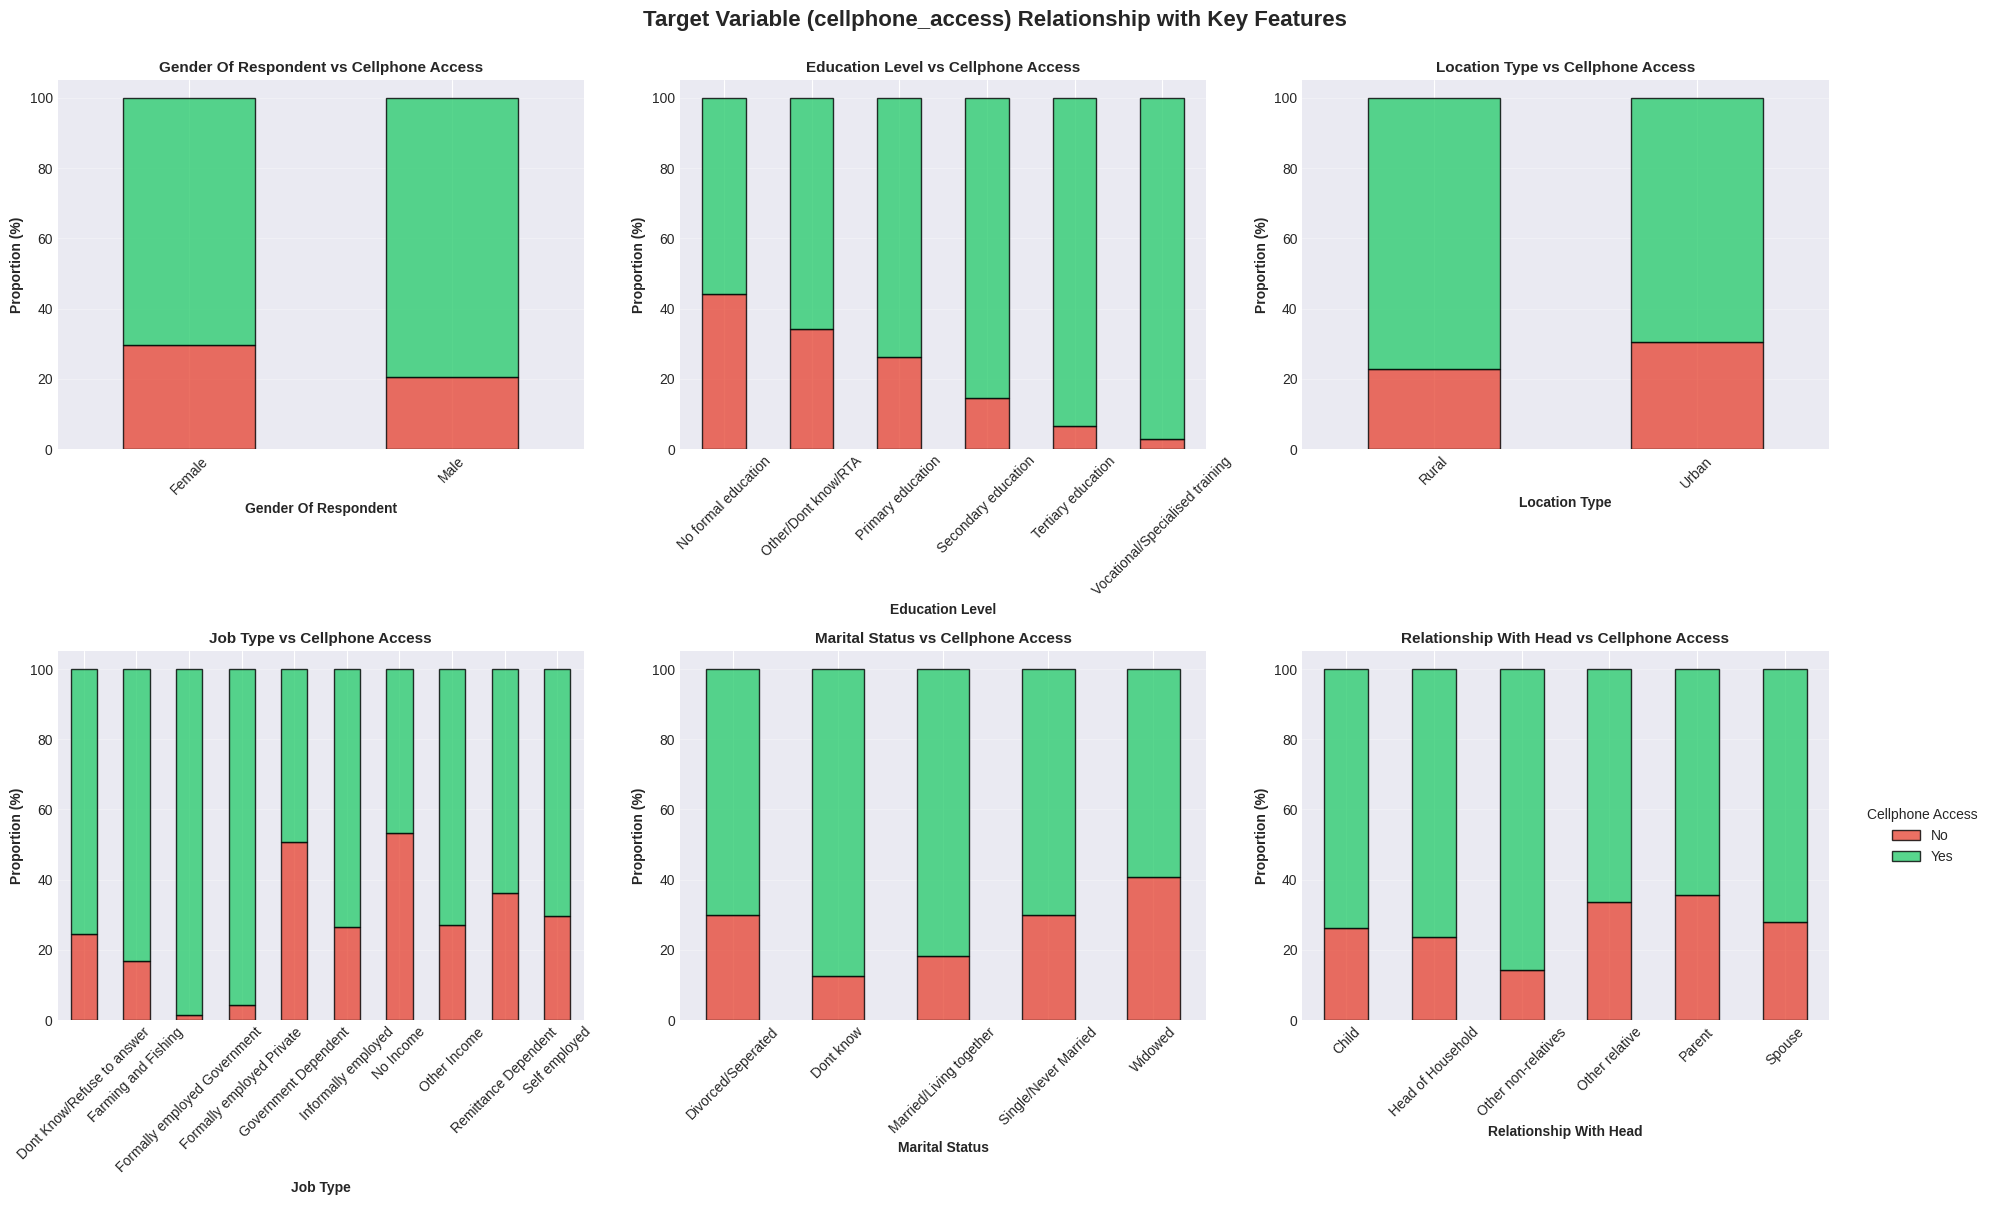

In [14]:
# ============================================================================
# SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "="*80)
print("SECTION 3: EXPLORATORY DATA ANALYSIS")
print("="*80)

# 3.1: Basic Dataset Statistics
print("\n--- 3.1: Basic Statistics ---")
print(df.describe(include='all'))

# 3.2: Identify column types
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\n--- 3.2: Column Types ---")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:5]}...")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols[:5]}...")

# 3.3: Missing Values Analysis
print("\n--- 3.3: Missing Values Analysis ---")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Column': missing_values.index,'Missing_Count': missing_values.values,'Percentage': missing_percent.values})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("No missing values detected - excellent data quality.")

# 3.4: Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n--- 3.4: Duplicate Check ---")
print(f"Duplicate rows: {duplicates}")

# 3.5: Identify target variable
print("\n--- 3.5: Target Variable Identification ---")
if 'cellphone_access' in df.columns:
    target_col = 'cellphone_access'
elif 'bank_account' in df.columns:
    target_col = 'bank_account'
else:
    # Assume last column is target
    target_col = df.columns[-1]

print(f"Target Variable: '{target_col}'")
print(f"\nTarget Distribution:")
print(df[target_col].value_counts())
print(f"\nTarget Proportions:")
print(df[target_col].value_counts(normalize=True).round(4))

# 3.6: Visualize target distribution
print("\n--- 3.6: Target Variable Visualization ---")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
target_counts = df[target_col].value_counts()
axes[0].bar(range(len(target_counts)), target_counts.values, color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
axes[0].set_xticks(range(len(target_counts)))
axes[0].set_xticklabels(target_counts.index, rotation=0)
axes[0].set_title(f'{target_col.replace("_", " ").title()} Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Add count labels
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + max(target_counts.values)*0.02, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',colors=['#e74c3c', '#2ecc71'], startangle=90, explode=[0.05, 0.05])
axes[1].set_title(f'{target_col.replace("_", " ").title()} Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Insight: The target variable shows {'relatively balanced' if 0.4 <= target_counts.min()/target_counts.sum() <= 0.6 else 'imbalanced'} classes.")

# 3.7: Categorical Variables Analysis
print("\n--- 3.7: Key Categorical Variables ---")
key_categorical = [col for col in categorical_cols if col not in [target_col, 'country', 'year', 'uniqueid']][:6]

for col in key_categorical:
    print(f"\n{col}:")
    print(df[col].value_counts().head(5))
    print(f"Total unique values: {df[col].nunique()}")

# 3.8: Visualize categorical features
print("\n--- 3.8: Categorical Features Visualization ---")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, col in enumerate(key_categorical):
    if idx < 6:
        value_counts = df[col].value_counts().head(8)
        axes[idx].barh(range(len(value_counts)), value_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
        axes[idx].set_yticks(range(len(value_counts)))
        axes[idx].set_yticklabels(value_counts.index, fontsize=9)
        axes[idx].set_xlabel('Count', fontweight='bold')
        axes[idx].set_title(f'{col.replace("_", " ").title()}', fontweight='bold', fontsize=11)
        axes[idx].invert_yaxis()
        axes[idx].grid(True, alpha=0.3, axis='x')

plt.suptitle('Distribution of Key Categorical Features', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# 3.9: Numerical Variables Analysis
print("\n--- 3.9: Numerical Variables Analysis ---")
if len(numerical_cols) > 1:
    print(df[numerical_cols].describe())

    # Visualize numerical distributions
    fig, axes = plt.subplots(1, min(3, len(numerical_cols)), figsize=(15, 4))
    if len(numerical_cols) == 1:
        axes = [axes]

    for idx, col in enumerate(numerical_cols[:3]):
        axes[idx].hist(df[col].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel(col.replace('_', ' ').title(), fontweight='bold')
        axes[idx].set_ylabel('Frequency', fontweight='bold')
        axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}', fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 3.10: Feature-Target Relationships
print("\n--- 3.10: Feature-Target Relationships ---")
relationship_features = ['gender_of_respondent', 'education_level', 'location_type', 'job_type', 'marital_status', 'relationship_with_head']
available_features = [f for f in relationship_features if f in df.columns]

if available_features:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()

    for idx, col in enumerate(available_features):
        if idx < 6:
            # Create a contingency table
            cross_tab = pd.crosstab(df[col], df[target_col], normalize='index') * 100
            cross_tab.plot(kind='bar', stacked=True, ax=axes[idx], legend=False,color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
            axes[idx].set_title(f'{col.replace("_", " ").title()} vs {target_col.replace("_", " ").title()}', fontweight='bold', fontsize=11)
            axes[idx].set_xlabel(col.replace('_', ' ').title(), fontweight='bold')
            axes[idx].set_ylabel('Proportion (%)', fontweight='bold')
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(True, alpha=0.3, axis='y')

    plt.suptitle(f'Target Variable (cellphone_access) Relationship with Key Features', fontsize=16, fontweight='bold', y=1.00)
    plt.legend(title=target_col.replace('_', ' ').title(), labels=['No', 'Yes'], bbox_to_anchor=(1.05, 0.5), loc='center left')
    plt.tight_layout()
    plt.show()

### Feature-Target Relationships

Understanding how different features relate to our target variable (cellphone access) is crucial for identifying potential talents who can use our platform. In this section, we:

1. Select key demographic and socioeconomic features
2. Analyze how cellphone access varies across different feature values
3. Visualize these relationships using stacked bar charts

These visualizations help us identify which variables have the strongest associations with digital access and might be the most predictive in our models. For example, we might discover that education level or urban/rural location significantly impacts a young person's ability to access our talent platform.

### Numerical Features Analysis

Numerical variables such as age, household size, or income can significantly impact a young person's digital access and thus their ability to showcase their talents on our platform. In this section, we:

1. Analyze the statistical properties of numerical features
2. Visualize their distributions using histograms
3. Identify potential outliers and skewness

Understanding the distributions of numerical features helps inform preprocessing decisions, such as whether to normalize or standardize the data, and may reveal important patterns related to who has the best access to join our talent platform.

### Categorical Features Analysis

Categorical variables such as gender, education level, and location type often have significant influence on digital access and thus on who can participate in our talent platform. In this section, we:

1. Identify key categorical variables (excluding ID fields and target)
2. Analyze their frequency distributions
3. Visualize the most common values using horizontal bar charts

This analysis helps us understand the demographic and socioeconomic composition of the dataset and identify potential patterns that might influence who has the best opportunity to showcase their artistic talents on our platform.

### Target Variable Analysis

We identify and analyze our target variable `cellphone_access`, which indicates whether an individual has access to a cellphone - critical for using our talent discovery platform. Understanding the distribution of the target variable is crucial for:

1. Detecting class imbalance, which might require special handling during modeling
2. Establishing a baseline accuracy (majority class frequency)
3. Visualizing the overall digital access levels in the dataset, which reflects potential platform reach

We'll use both bar plots and pie charts to clearly visualize the target distribution and better understand our potential user base.

### Data Quality Assessment

Next, we assess the quality of our dataset by checking for missing values and duplicate records. Missing values can significantly impact model performance and may require imputation or row removal. Duplicates might skew our analysis and lead to biased results about which regions have the most potential talent with digital access.

## Exploratory Data Analysis (EDA)

This section performs a comprehensive exploratory analysis of the dataset to understand the underlying patterns and relationships that will help us identify potential talent for our platform. The EDA includes:

1. Basic statistics to understand the distribution of variables
2. Identifying data types (categorical vs numerical features)
3. Data quality checks (missing values and duplicates)
4. Target variable analysis
5. Visualization of key features
6. Analysis of relationships between features and digital access

The insights gained from this EDA will guide our feature engineering and modeling decisions to effectively identify regions and demographics with the highest potential for talent discovery.

### Basic Dataset Statistics and Column Types

We begin the EDA by examining the basic statistics of the dataset using `describe()`, which provides summary statistics for numerical features (count, mean, std, min, max, quartiles) and frequency information for categorical features.

We'll also identify the column types in our dataset, separating them into categorical and numerical features. This is crucial as different feature types require different preprocessing techniques and visualization approaches to effectively identify our potential talent pool.

In [15]:
# ============================================================================
# SECTION 4: DATA PREPROCESSING, FEATURE ENGINEERING & SPLITTING
# ============================================================================

print("\n" + "="*80)
print("SECTION 4: DATA PREPROCESSING, FEATURE ENGINEERING & SPLITTING")
print("="*80)

# Define feature columns and target
target_col = 'cellphone_access'

# Drop target and ID/year columns safely (only drop if present)
drop_cols = [c for c in [target_col, 'uniqueid', 'year'] if c in df.columns]
X = df.drop(columns=drop_cols)

# ---Clean and encode target column safely ---
print("\nChecking target variable unique values before encoding:")
print(df[target_col].unique())

y = df[target_col].astype(str).str.strip().str.lower()
y = y.map({'yes': 1, 'no': 0, '1': 1, '0': 0})

if y.isnull().any():
    print("Warning: Some target values are unexpected. Filling them with 0.")
    print("Unexpected values detected:", df.loc[y.isnull(), target_col].unique())
    y = y.fillna(0)

y = y.astype(int)
print("\nTarget value counts after encoding:")
print(y.value_counts())

# Handle Missing Values (Simple imputation strategy)
X_processed = X.copy()

# For object/categorical columns, fill with mode (if mode exists)
for col in X_processed.select_dtypes(include=['object', 'category']).columns:
    if X_processed[col].isnull().all():
        X_processed[col] = X_processed[col].fillna('missing')
    else:
        X_processed[col] = X_processed[col].fillna(X_processed[col].mode().iloc[0])

# For numeric columns, fill with median
for col in X_processed.select_dtypes(include=[np.number]).columns:
    X_processed[col] = X_processed[col].fillna(X_processed[col].median())

# Separate features by type
numerical_features = X_processed.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_processed.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nDetected numerical features ({len(numerical_features)}): {numerical_features[:8]}...")
print(f"Detected categorical features ({len(categorical_features)}): {categorical_features[:8]}...")

encoder_args = {"handle_unknown": "ignore"}
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    encoder_args["sparse_output"] = False
else:
    encoder_args["sparse"] = False

# Build ColumnTransformer
transformers = []
if len(numerical_features) > 0:
    transformers.append(('num', StandardScaler(), numerical_features))
if len(categorical_features) > 0:
    transformers.append(('cat', OneHotEncoder(**encoder_args), categorical_features))

if len(transformers) == 0:
    print("Warning: No transformers found. Using passthrough.")
    preprocessor = ColumnTransformer(transformers=[], remainder='passthrough')
else:
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

X_preprocessed = preprocessor.fit_transform(X_processed)

# Ensure dense array
if hasattr(X_preprocessed, "toarray"):
    X_preprocessed = X_preprocessed.toarray()

print(f"\nPreprocessed feature matrix shape: {X_preprocessed.shape}")

# Build feature names robustly
feature_names = []
if len(numerical_features) > 0:
    feature_names.extend(numerical_features)

one_hot_feature_names = []
if len(categorical_features) > 0:
    try:
        encoder = preprocessor.named_transformers_.get('cat', None)
        if encoder is not None:
            one_hot_feature_names = encoder.get_feature_names_out(categorical_features).tolist()
            feature_names.extend(one_hot_feature_names)
    except Exception as e:
        print("Could not get one-hot encoder feature names:", e)

if X_preprocessed.shape[1] != len(feature_names):
    print("Mismatch between produced columns and feature names.")
    feature_names = [f"f_{i}" for i in range(X_preprocessed.shape[1])]
else:
    print(f"Feature count matches: {len(feature_names)} features.")

X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)
X = X_preprocessed_df

# 4.1: Train-Validation-Test Split (60% Train, 20% Validation, 20% Test)
print("\n--- 4.1: Train-Validation-Test Split ---")
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_full
)  # 0.25 of 80% is 20%

print(f"Original shape: {X.shape}")
print(f"Training set shape: {X_train.shape}, Target ratio: {y_train.value_counts(normalize=True).round(4).to_dict()}")
print(f"Validation set shape: {X_val.shape}, Target ratio: {y_val.value_counts(normalize=True).round(4).to_dict()}")
print(f"Test set shape: {X_test.shape}, Target ratio: {y_test.value_counts(normalize=True).round(4).to_dict()}")

# Keep consistent naming for later steps
X_train_scaled = X_train
X_val_scaled = X_val
X_test_scaled = X_test

# 4.2: Handle Imbalanced Data using SMOTE
print("\n--- 4.2: Imbalanced Data Handling (SMOTE on Training Set) ---")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Balanced Training set shape: {X_train_balanced.shape}")
print(f"Balanced Target ratio: {y_train_balanced.value_counts(normalize=True).round(4).to_dict()}")

# Ensure X_train is defined for feature analysis
X_train = X_train_scaled


SECTION 4: DATA PREPROCESSING, FEATURE ENGINEERING & SPLITTING

Checking target variable unique values before encoding:
['Yes' 'No']

Target value counts after encoding:
cellphone_access
1    17454
0     6070
Name: count, dtype: int64

Detected numerical features (2): ['household_size', 'age_of_respondent']...
Detected categorical features (8): ['country', 'bank_account', 'location_type', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']...

Preprocessed feature matrix shape: (23524, 39)
Feature count matches: 39 features.

--- 4.1: Train-Validation-Test Split ---
Original shape: (23524, 39)
Training set shape: (14114, 39), Target ratio: {1: 0.742, 0: 0.258}
Validation set shape: (4705, 39), Target ratio: {1: 0.742, 0: 0.258}
Test set shape: (4705, 39), Target ratio: {1: 0.742, 0: 0.258}

--- 4.2: Imbalanced Data Handling (SMOTE on Training Set) ---
Balanced Training set shape: (20944, 39)
Balanced Target ratio: {1: 0.5, 0: 0.5}


## Data Preprocessing, Feature Engineering & Splitting

In this section, we prepare our data for modeling by:

1. **Feature Selection**: Selecting relevant variables that best predict digital access among potential talents
2. **Feature Engineering**: Creating new features that might improve our ability to identify promising regions for talent discovery
3. **Encoding Categorical Variables**: Converting categorical variables into a format suitable for machine learning algorithms
4. **Handling Missing Values**: Addressing any remaining missing values through imputation or removal
5. **Feature Scaling**: Standardizing or normalizing numerical features for algorithms sensitive to scale
6. **Train-Test Split**: Dividing our data into training, validation, and test sets
7. **Class Imbalance Handling**: Addressing any imbalance in the target variable distribution

Proper preprocessing is crucial for ensuring our models can effectively learn which individuals have the digital access needed to participate in our talent platform.


TRADITIONAL MACHINE LEARNING EXPERIMENTS

----------------------------------------------------------------------
EXPERIMENT 1: Logistic Regression (Baseline)
----------------------------------------------------------------------
Training Logistic Regression...
Training completed

EXPERIMENT 1: Logistic Regression RESULTS
Hyperparameters: C=1.0, solver='lbfgs', max_iter=1000

Metric          Train        Validation   Test        
---------------------------------------------------
Accuracy        0.6758     0.6903     0.6797
Precision       0.8826     0.8915     0.8783
Recall          0.6494     0.6634     0.6597
F1-Score        0.7483     0.7607     0.7535
AUC-ROC         0.7721     0.7791     0.7684
---------------------------------------------------


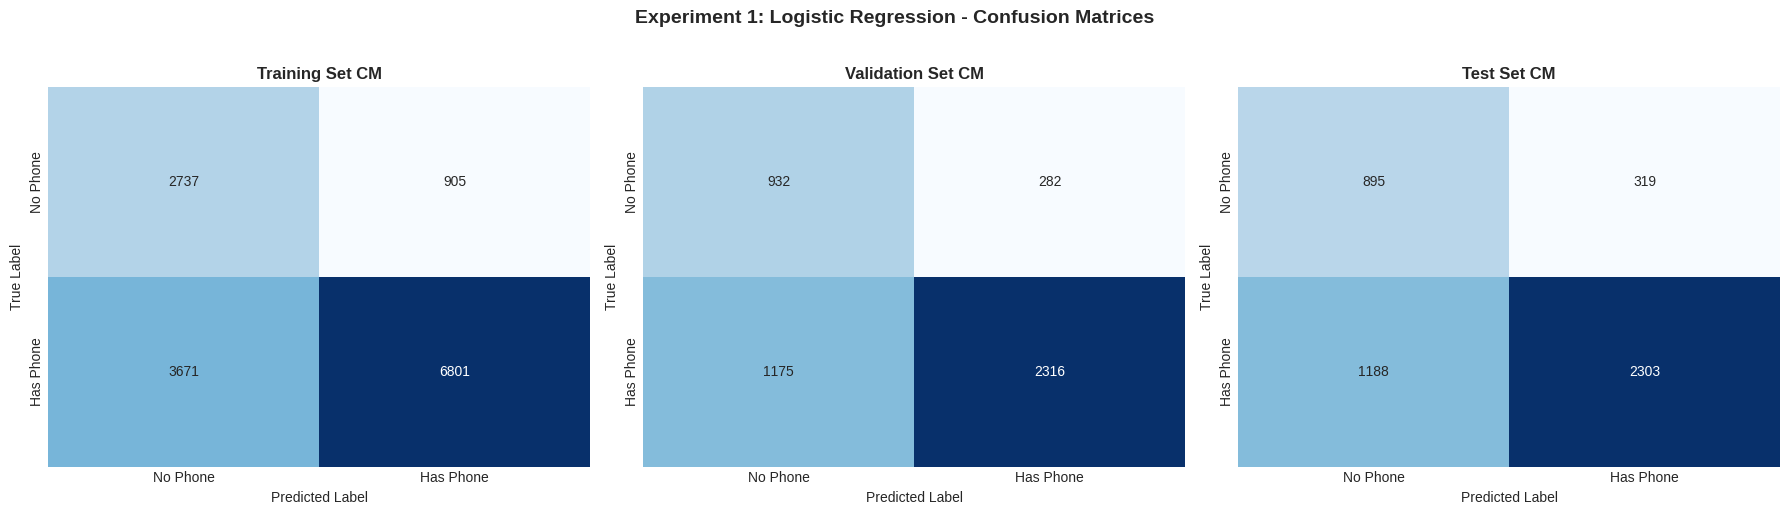

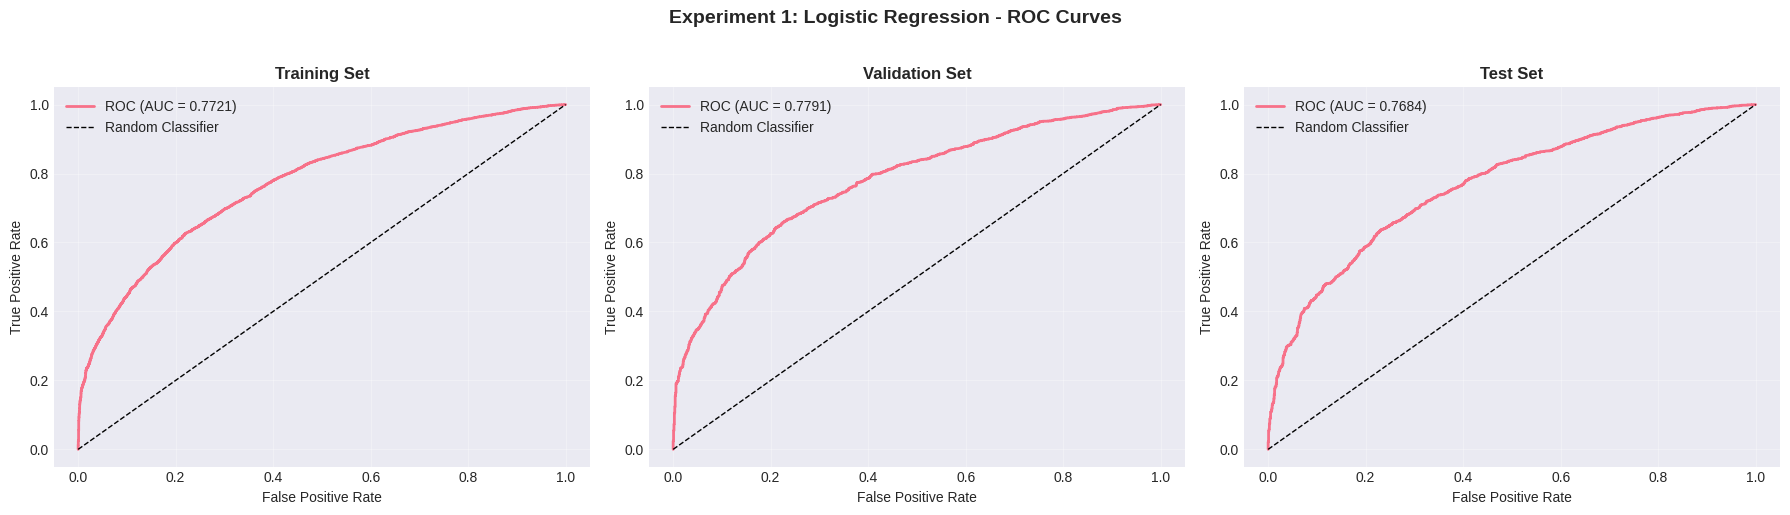


Top 10 Most Important Features (by coefficient magnitude):
                                            feature  coefficient
28  education_level_Vocational/Specialised training       1.5657
27               education_level_Tertiary education       1.5397
14       relationship_with_head_Other non-relatives       1.4560
32               job_type_Formally employed Private       1.4193
23              education_level_No formal education       1.3831
7                                  bank_account_Yes       1.2602
3                                    country_Rwanda       0.9325
31            job_type_Formally employed Government       0.8915
6                                   bank_account_No       0.8132
24              education_level_Other/Dont know/RTA       0.7395

----------------------------------------------------------------------
EXPERIMENT 2: Random Forest (Default)
----------------------------------------------------------------------
Training Random Forest...
✓ Training complet

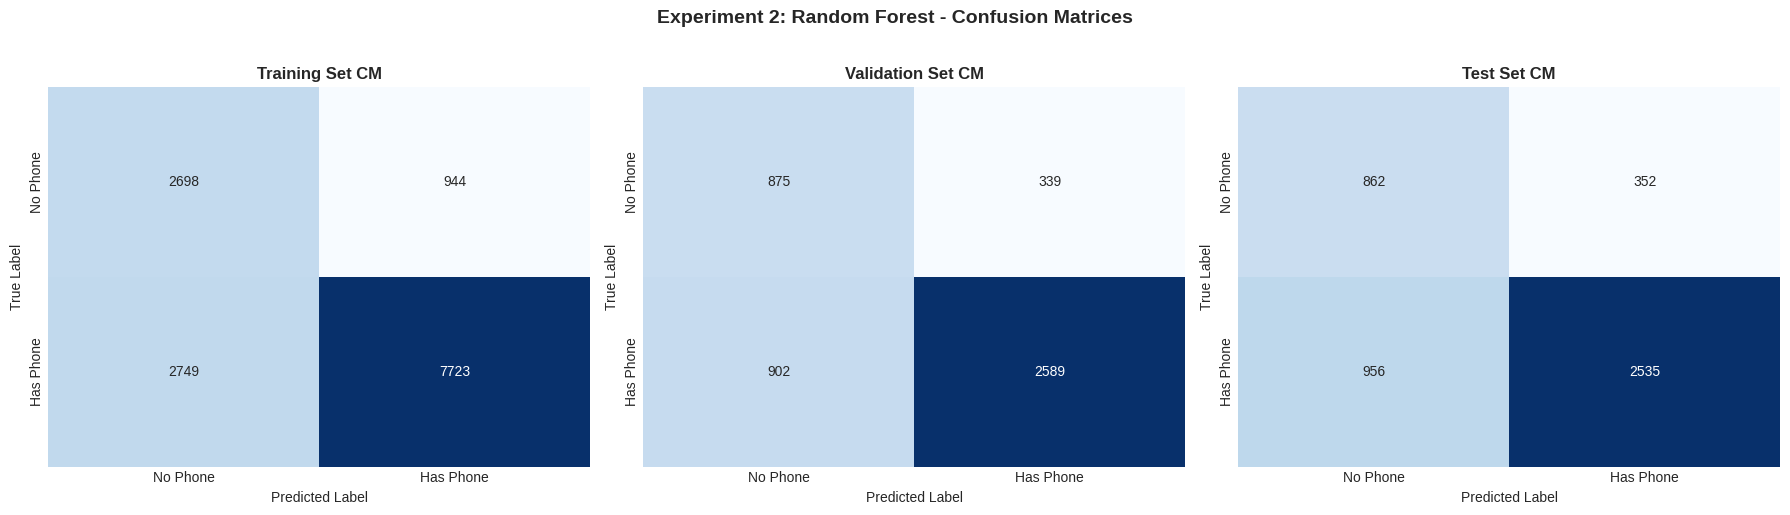

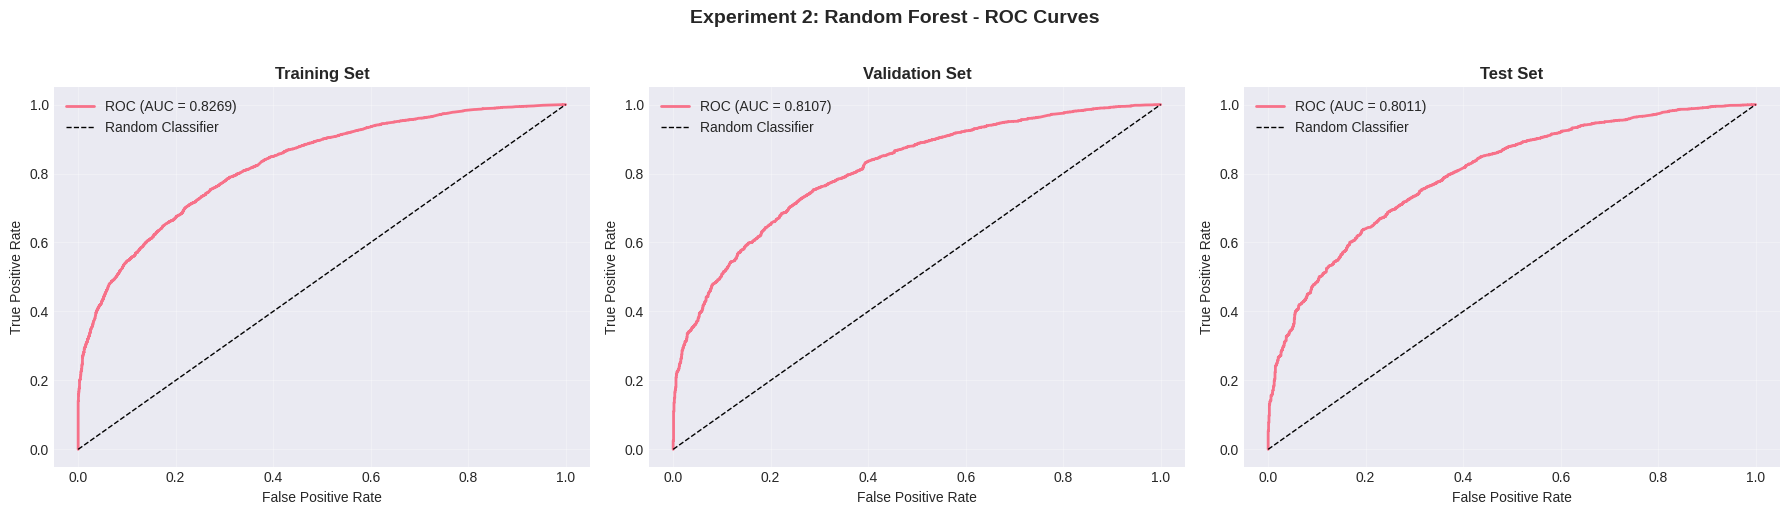


----------------------------------------------------------------------
EXPERIMENT 3: Random Forest (Hyperparameter Tuned)
----------------------------------------------------------------------
Training Tuned Random Forest...
Training completed

EXPERIMENT 3: Random Forest (Tuned) RESULTS
Hyperparameters: n_estimators=200, max_depth=15, min_samples_split=10, max_features='sqrt'

Metric          Train        Validation   Test        
---------------------------------------------------
Accuracy        0.7704     0.7460     0.7360
Precision       0.8963     0.8759     0.8708
Recall          0.7809     0.7663     0.7565
F1-Score        0.8347     0.8174     0.8096
AUC-ROC         0.8508     0.8102     0.8030
---------------------------------------------------


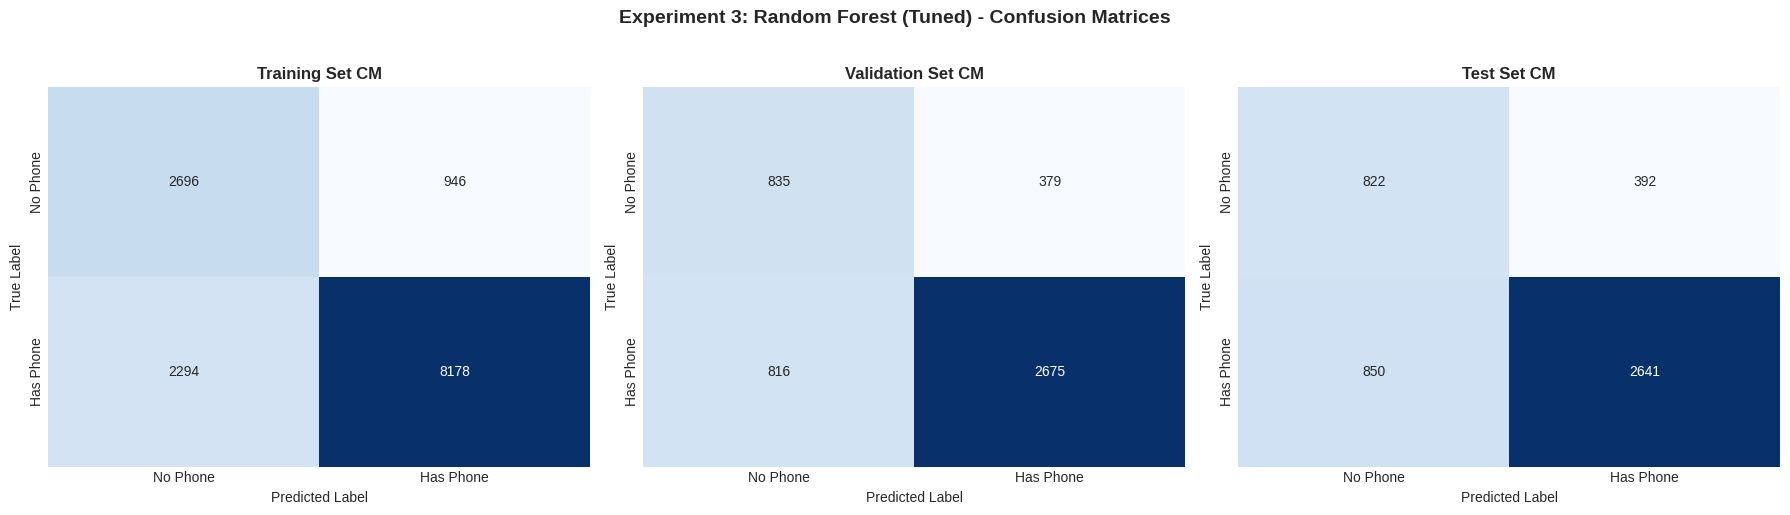

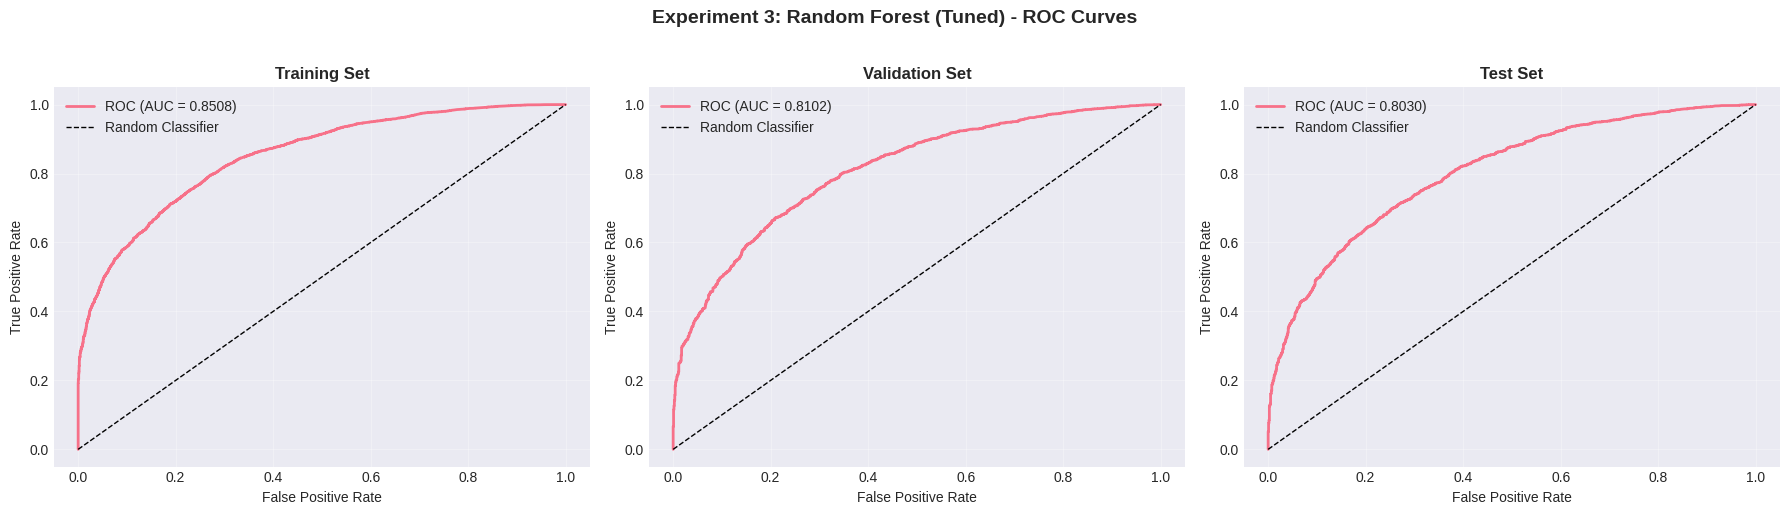


----------------------------------------------------------------------
EXPERIMENT 4: XGBoost (Default)
----------------------------------------------------------------------
Training XGBoost...
Training completed

EXPERIMENT 4: XGBoost RESULTS
Hyperparameters: n_estimators=100, max_depth=6, learning_rate=0.1

Metric          Train        Validation   Test        
---------------------------------------------------
Accuracy        0.7755     0.7715     0.7511
Precision       0.8758     0.8687     0.8607
Recall          0.8126     0.8152     0.7929
F1-Score        0.8430     0.8411     0.8254
AUC-ROC         0.8349     0.8142     0.8009
---------------------------------------------------


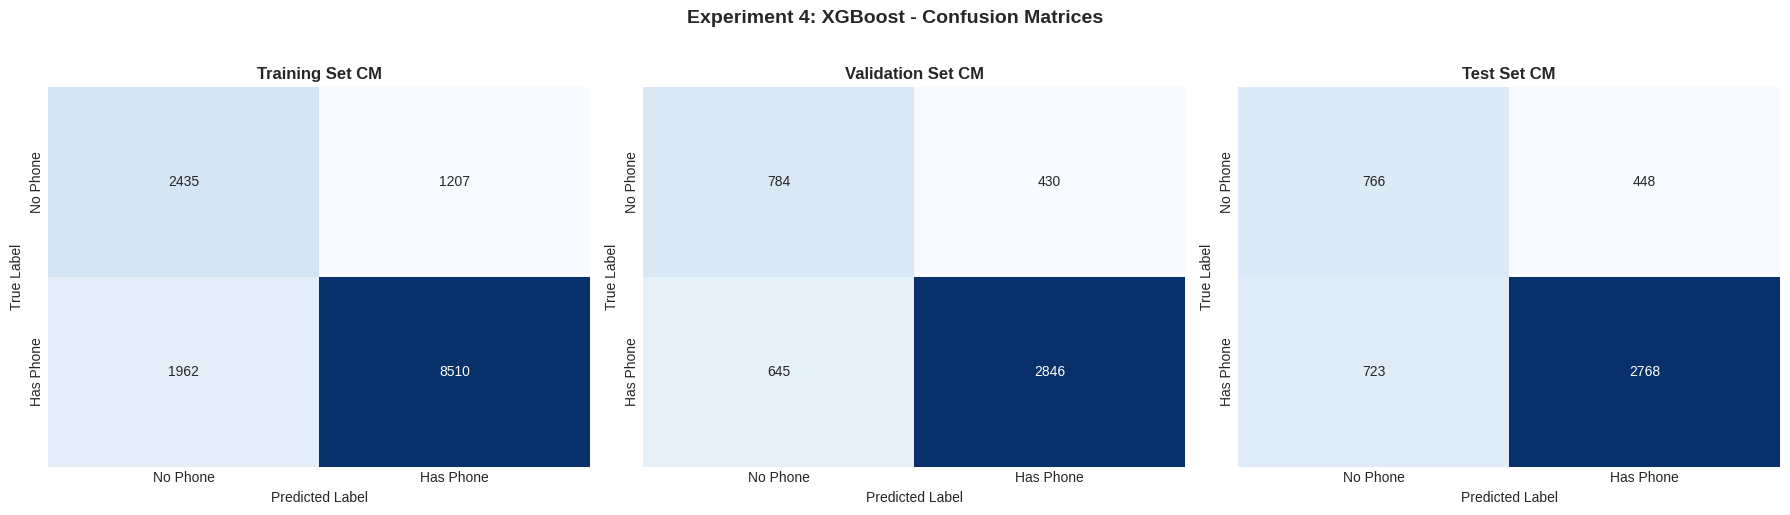

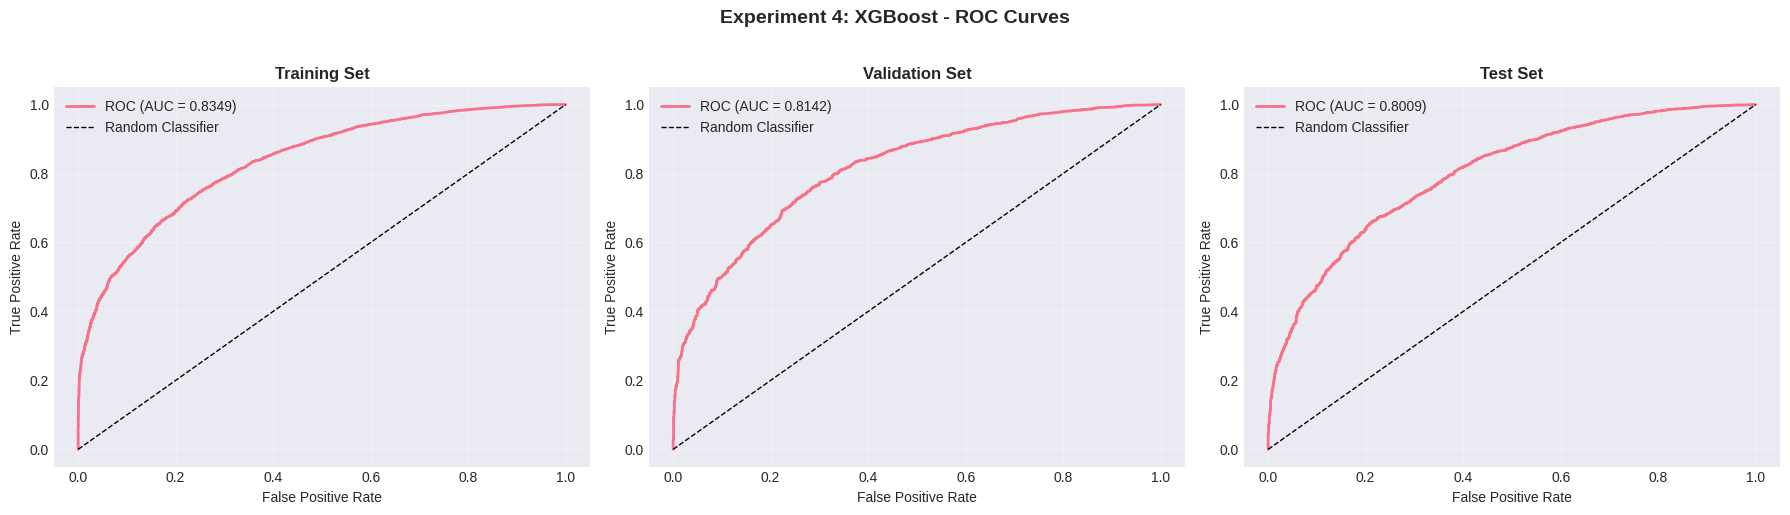


----------------------------------------------------------------------
EXPERIMENT 5: XGBoost (Tuned + Regularization)
----------------------------------------------------------------------
Training Tuned XGBoost...
Training completed

EXPERIMENT 5: XGBoost (Tuned) RESULTS
Hyperparameters: n_estimators=150, max_depth=5, lr=0.05, subsample=0.8, reg_alpha=0.1, reg_lambda=1.0

Metric          Train        Validation   Test        
---------------------------------------------------
Accuracy        0.7473     0.7556     0.7356
Precision       0.8738     0.8777     0.8666
Recall          0.7707     0.7791     0.7608
F1-Score        0.8190     0.8255     0.8103
AUC-ROC         0.8178     0.8154     0.8017
---------------------------------------------------


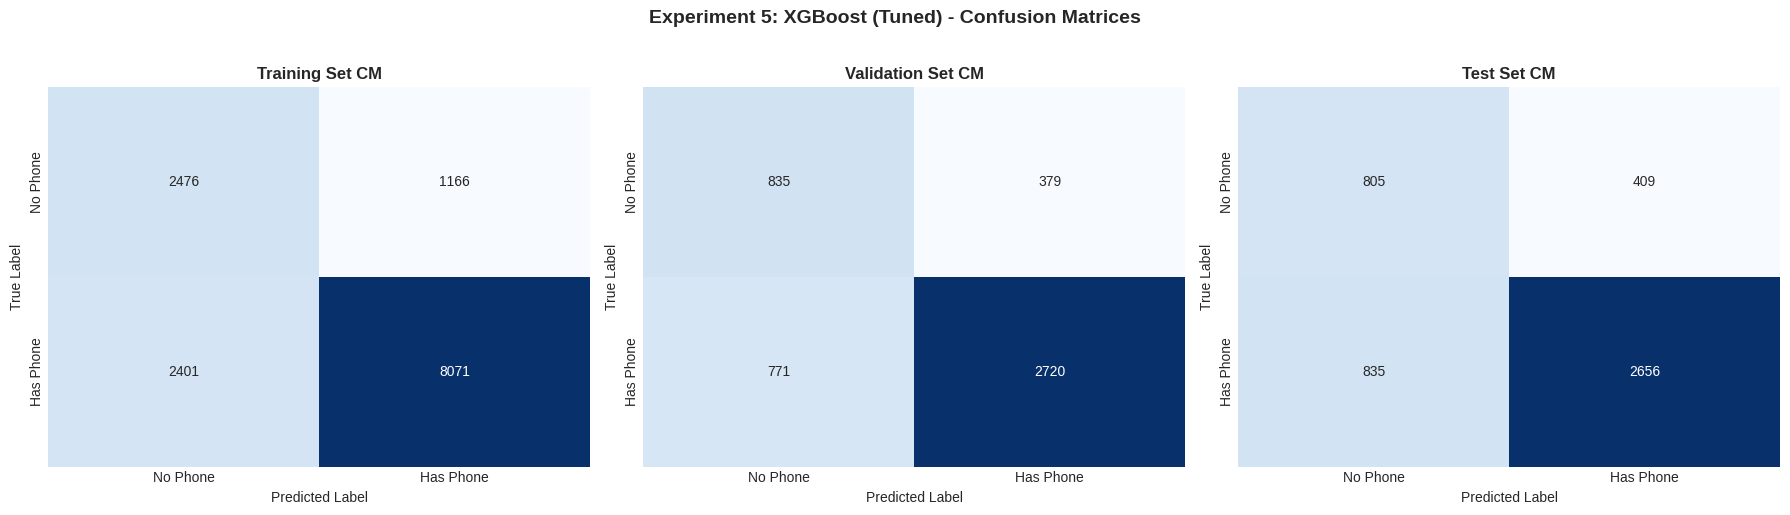

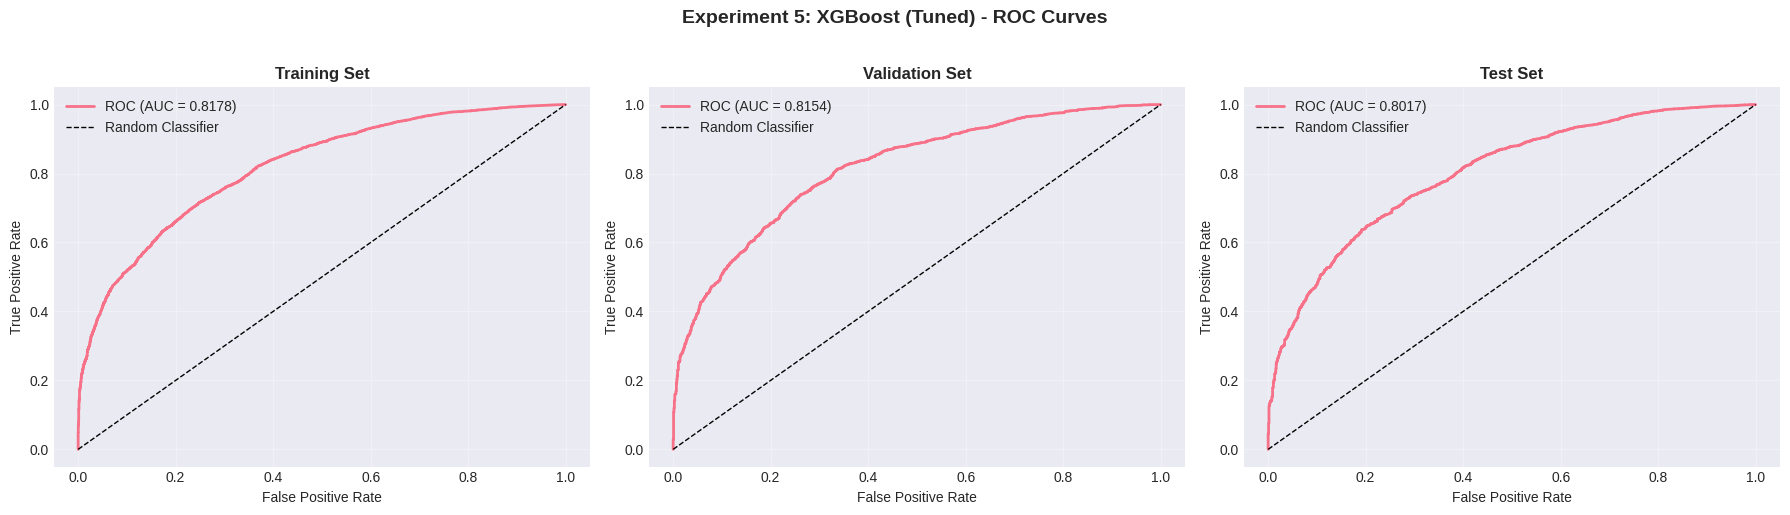


----------------------------------------------------------------------
EXPERIMENT 6: Gradient Boosting Classifier
----------------------------------------------------------------------
Training Gradient Boosting...
Training completed

EXPERIMENT 6: Gradient Boosting RESULTS
Hyperparameters: n_estimators=150, learning_rate=0.1, max_depth=5, subsample=0.8

Metric          Train        Validation   Test        
---------------------------------------------------
Accuracy        0.7935     0.7813     0.7639
Precision       0.8605     0.8515     0.8439
Recall          0.8613     0.8542     0.8364
F1-Score        0.8609     0.8529     0.8402
AUC-ROC         0.8378     0.8120     0.8016
---------------------------------------------------


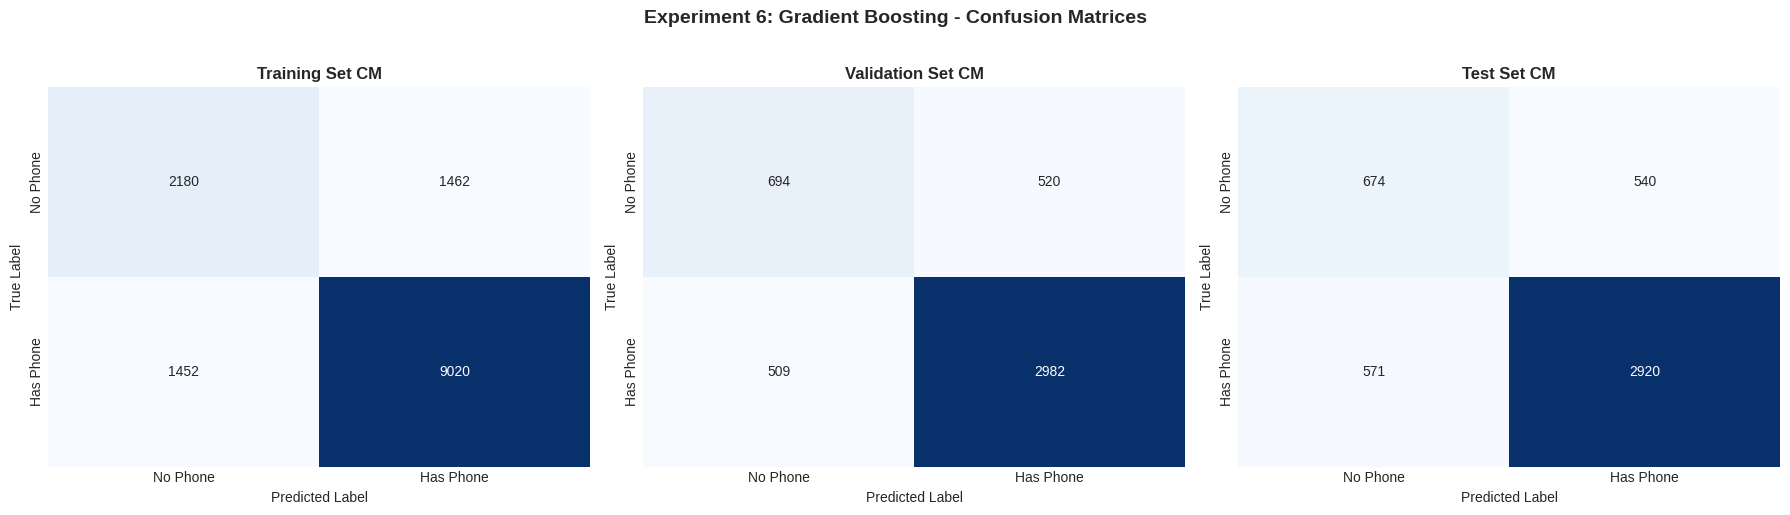

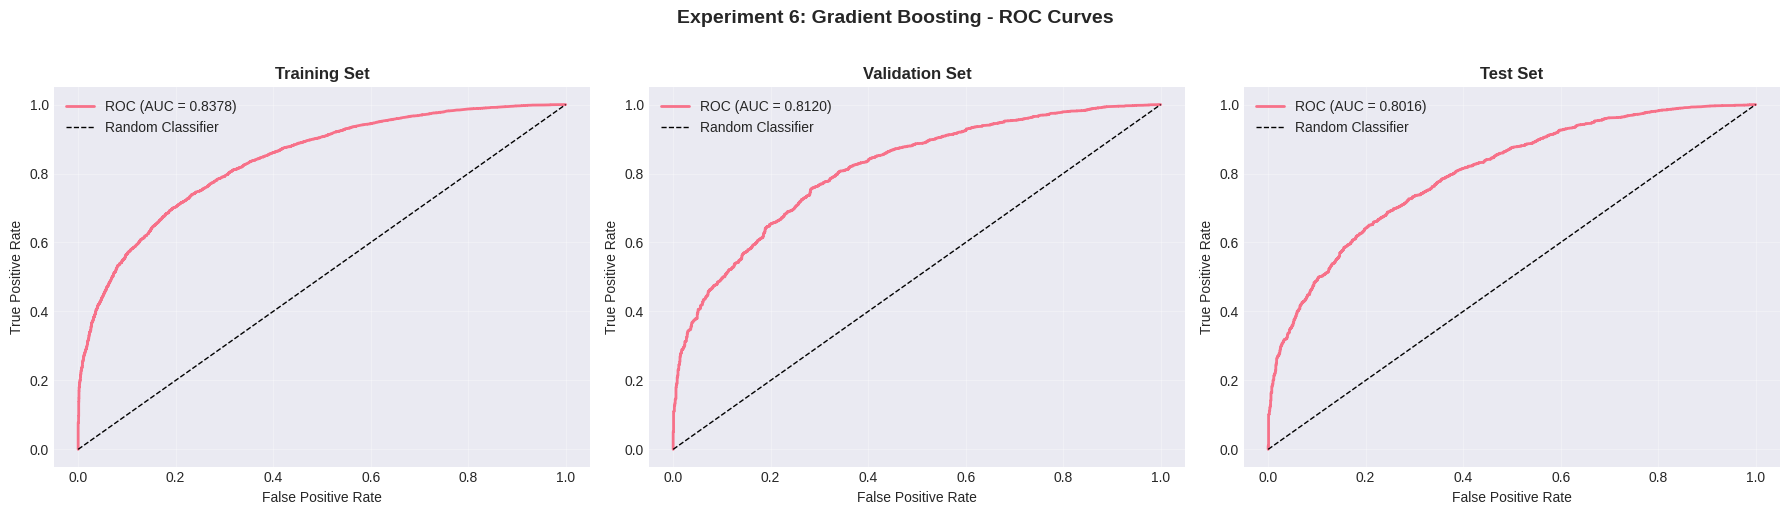

In [16]:
# ============================================================================
# SECTION 5: TRADITIONAL MACHINE LEARNING EXPERIMENTS
# ============================================================================

print("\n" + "="*80)
print("TRADITIONAL MACHINE LEARNING EXPERIMENTS")
print("="*80)

# -----------------------------------------------------------------------------
# EXPERIMENT 1: Logistic Regression (Baseline)
# -----------------------------------------------------------------------------

print("\n" + "-"*70)
print("EXPERIMENT 1: Logistic Regression (Baseline)")
print("-"*70)

lr_model = LogisticRegression(
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Training Logistic Regression...")
lr_model.fit(X_train_balanced, y_train_balanced)
print("Training completed")

results_1 = evaluate_model(
    model=lr_model,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Logistic Regression",
    experiment_num=1,
    hyperparams="C=1.0, solver='lbfgs', max_iter=1000",
    notes="Baseline model. Linear decision boundary. Good for understanding feature importance and interpretability."
)

experiment_results.append(results_1)

# Analyze feature coefficients
print("\nTop 10 Most Important Features (by coefficient magnitude):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': np.abs(lr_model.coef_[0])
}).sort_values('coefficient', ascending=False)
print(feature_importance.head(10))

# -----------------------------------------------------------------------------
# EXPERIMENT 2: Random Forest (Default)
# -----------------------------------------------------------------------------

print("\n" + "-"*70)
print("EXPERIMENT 2: Random Forest (Default)")
print("-"*70)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train_balanced, y_train_balanced)
print("✓ Training completed")

results_2 = evaluate_model(
    model=rf_model,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Random Forest",
    experiment_num=2,
    hyperparams="n_estimators=100, max_depth=10, min_samples_split=5",
    notes="Captures non-linear patterns and feature interactions. Expected improvement over linear baseline."
)

experiment_results.append(results_2)

# -----------------------------------------------------------------------------
# EXPERIMENT 3: Random Forest (Hyperparameter Tuned)
# -----------------------------------------------------------------------------

print("\n" + "-"*70)
print("EXPERIMENT 3: Random Forest (Hyperparameter Tuned)")
print("-"*70)

rf_tuned = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Training Tuned Random Forest...")
rf_tuned.fit(X_train_balanced, y_train_balanced)
print("Training completed")

results_3 = evaluate_model(
    model=rf_tuned,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Random Forest (Tuned)",
    experiment_num=3,
    hyperparams="n_estimators=200, max_depth=15, min_samples_split=10, max_features='sqrt'",
    notes="Improved generalization through deeper trees and more estimators. Better bias-variance tradeoff."
)

experiment_results.append(results_3)

# -----------------------------------------------------------------------------
# EXPERIMENT 4: XGBoost (Default)
# -----------------------------------------------------------------------------

print("\n" + "-"*70)
print("EXPERIMENT 4: XGBoost (Default)")
print("-"*70)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)

print("Training XGBoost...")
xgb_model.fit(X_train_balanced, y_train_balanced)
print("Training completed")

results_4 = evaluate_model(
    model=xgb_model,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="XGBoost",
    experiment_num=4,
    hyperparams="n_estimators=100, max_depth=6, learning_rate=0.1",
    notes="Gradient boosting typically provides strong performance. Sequential tree building captures complex patterns."
)

experiment_results.append(results_4)

# -----------------------------------------------------------------------------
# EXPERIMENT 5: XGBoost (Tuned with Regularization)
# -----------------------------------------------------------------------------

print("\n" + "-"*70)
print("EXPERIMENT 5: XGBoost (Tuned + Regularization)")
print("-"*70)

xgb_tuned = XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)

print("Training Tuned XGBoost...")
xgb_tuned.fit(X_train_balanced, y_train_balanced)
print("Training completed")

results_5 = evaluate_model(
    model=xgb_tuned,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="XGBoost (Tuned)",
    experiment_num=5,
    hyperparams="n_estimators=150, max_depth=5, lr=0.05, subsample=0.8, reg_alpha=0.1, reg_lambda=1.0",
    notes="Regularization reduces overfitting. Lower learning rate with more trees provides smoother learning. Expected best traditional ML model."
)

experiment_results.append(results_5)

# -----------------------------------------------------------------------------
# EXPERIMENT 6: Gradient Boosting Classifier
# -----------------------------------------------------------------------------

print("\n" + "-"*70)
print("EXPERIMENT 6: Gradient Boosting Classifier")
print("-"*70)

gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=RANDOM_STATE
)

print("Training Gradient Boosting...")
gb_model.fit(X_train_balanced, y_train_balanced)
print("Training completed")

results_6 = evaluate_model(
    model=gb_model,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Gradient Boosting",
    experiment_num=6,
    hyperparams="n_estimators=150, learning_rate=0.1, max_depth=5, subsample=0.8",
    notes="Sklearn's GB implementation. Slower than XGBoost but often competitive. Good regularization with subsample."
)

experiment_results.append(results_6)

## Model Training and Evaluation

In this section, we implement and compare multiple machine learning models for identifying young individuals with digital access who could use our talent platform. We evaluate both traditional machine learning algorithms and deep learning approaches.

### Traditional Machine Learning Models
1. **Logistic Regression**: A simple baseline model that provides interpretable results
2. **Random Forest**: An ensemble method that builds multiple decision trees and aggregates their predictions
3. **XGBoost**: A gradient boosting algorithm known for its performance on tabular data
4. **SVM (Support Vector Machine)**: A powerful algorithm for classification tasks

### Deep Learning Models
1. **Simple Neural Network**: A baseline multi-layer perceptron
2. **Deep Neural Network**: A more complex architecture with multiple hidden layers
3. **Feature Embedding Networks**: Neural networks that learn embeddings for categorical variables

Each model is evaluated using multiple metrics including accuracy, precision, recall, F1-score, and ROC-AUC. We'll visualize the performance using confusion matrices and ROC curves to determine which model best identifies our potential talent pool.


DEEP LEARNING EXPERIMENTS
Input dimension: 39
Training samples: 20944

----------------------------------------------------------------------
EXPERIMENT 7: Simple Neural Network (Sequential API)
----------------------------------------------------------------------

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,185 (20.25 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 0 (0.00 B)


Training Simple Neural Network...
Epoch 1/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6167 - auc: 0.6686 - loss: 0.6397 - val_accuracy: 0.6572 - val_auc: 0.7945 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 2/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6990 - auc: 0.7757 - loss: 0.5599 - val_accuracy: 0.6631 - val_auc: 0.8033 - val_loss: 0.5516 - learning_rate: 0.0010
Epoch 3/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7116 - auc: 0.7891 - loss: 0.5483 - val_accuracy: 0.6939 - val_auc: 0.8063 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 4/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7177 - auc: 0.7987 - loss: 0.5378 - val_accuracy: 0.6882 - val_auc: 0.8068 - val_loss: 0.5374 - learning_rate: 0.0010
Epoch 5/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7223 - auc: 0.8039 - loss: 0.5326 - val_accuracy: 0.7044 - val_auc: 0.8081 - val_loss: 0.5295 - learning_rate: 0.0010
Epoch 6/100
328/328 ━━━━━━━━━━━━━━━━━━━

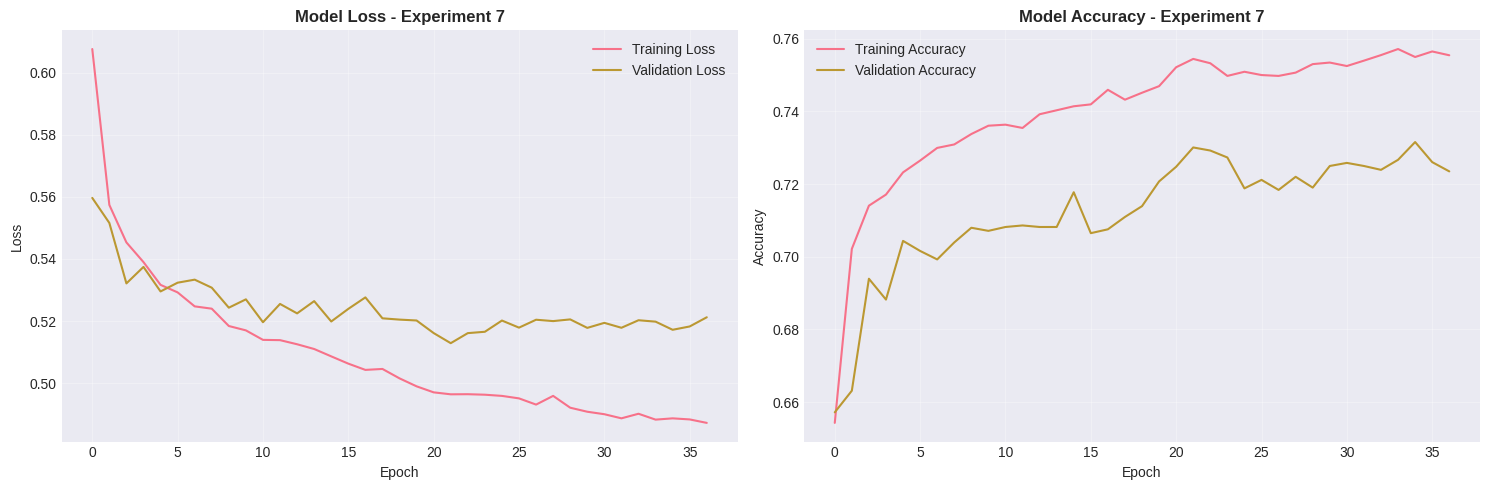

655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

EXPERIMENT 7: Simple Neural Network RESULTS
Hyperparameters: layers=[64,32,16], dropout=0.3, lr=0.001, batch_size=64

Metric          Train        Validation   Test        
---------------------------------------------------
Accuracy        0.7638     0.7301     0.7186
Precision       0.7815     0.8857     0.8844
Recall          0.7321     0.7304     0.7141
F1-Score        0.7560     0.8006     0.7902
AUC-ROC         0.8474     0.8047     0.7996
---------------------------------------------------


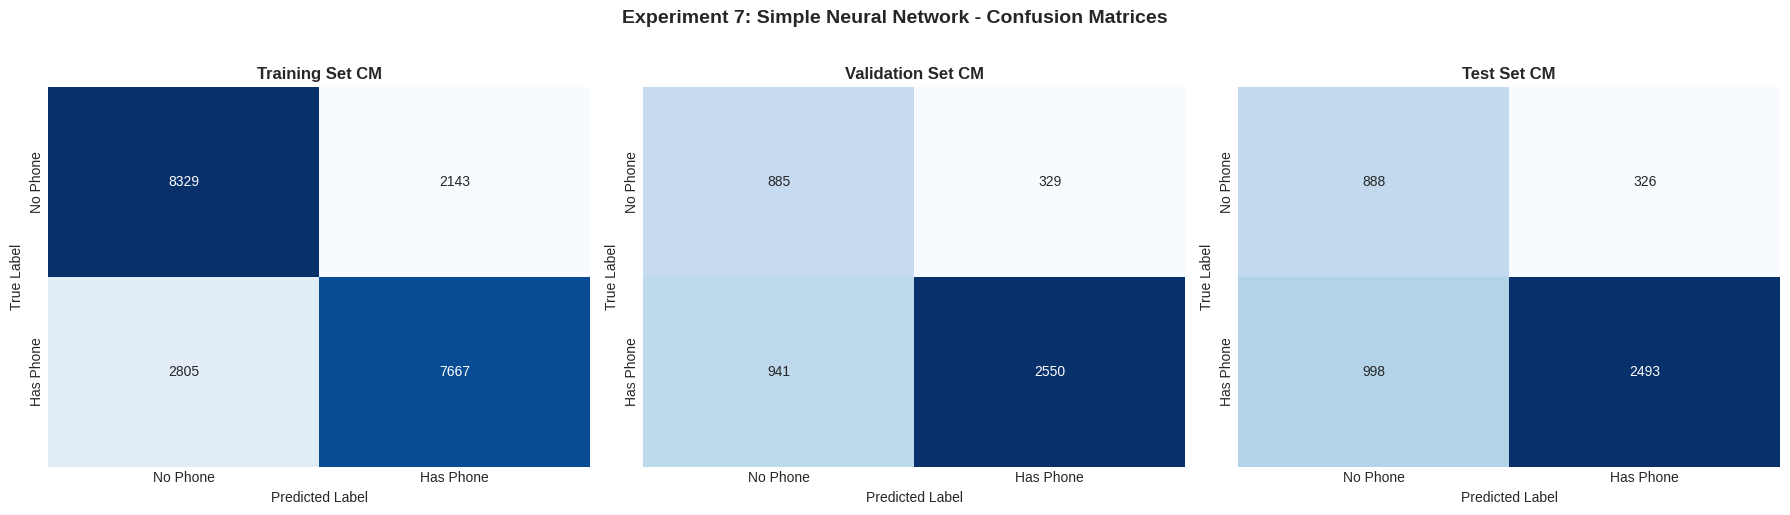

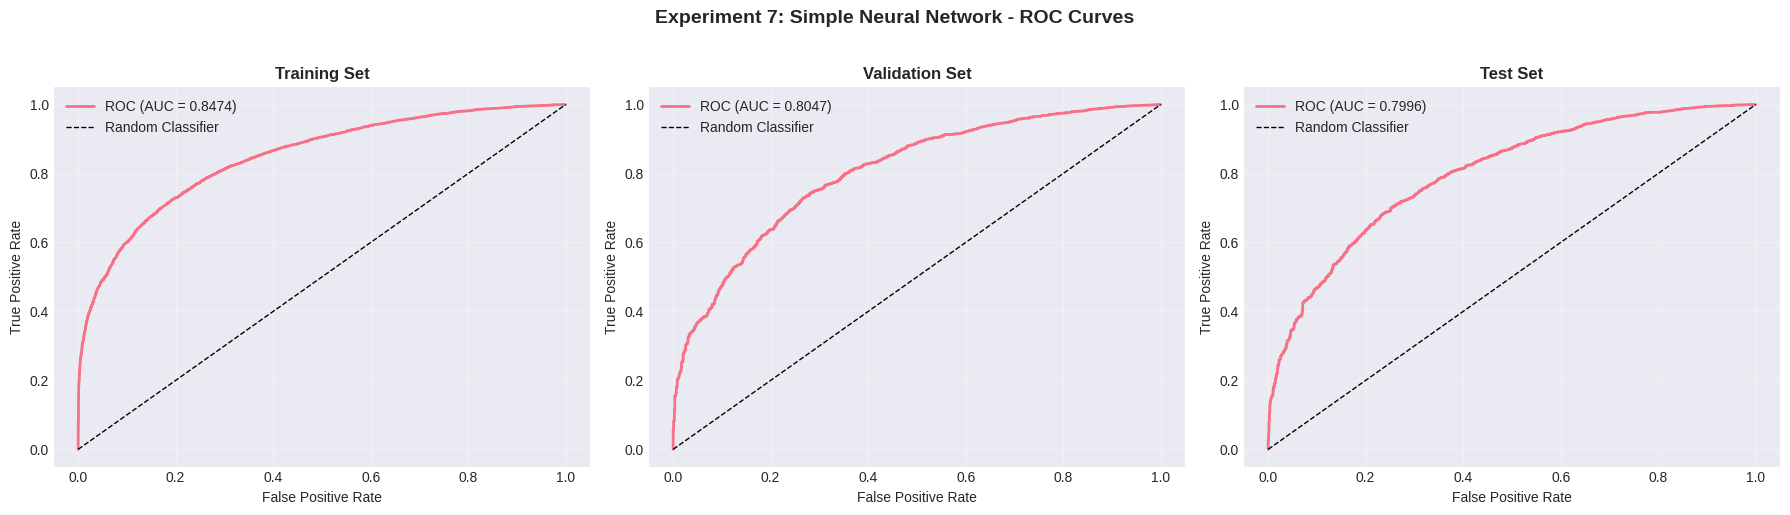


----------------------------------------------------------------------
EXPERIMENT 8: Deep Neural Network + Batch Normalization
----------------------------------------------------------------------

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,897 (66.00 KB)

 Trainable params: 16,449 (64.25 KB)

 Non-trainable params: 448 (1.75 KB)


Training Deep Neural Network...
Epoch 1/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5568 - auc: 0.5817 - loss: 0.7906 - val_accuracy: 0.7218 - val_auc: 0.7734 - val_loss: 0.5726 - learning_rate: 0.0010
Epoch 2/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6539 - auc: 0.7222 - loss: 0.6094 - val_accuracy: 0.7333 - val_auc: 0.7989 - val_loss: 0.5298 - learning_rate: 0.0010
Epoch 3/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6891 - auc: 0.7621 - loss: 0.5763 - val_accuracy: 0.7243 - val_auc: 0.8021 - val_loss: 0.5179 - learning_rate: 0.0010
Epoch 4/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7021 - auc: 0.7792 - loss: 0.5591 - val_accuracy: 0.7211 - val_auc: 0.8039 - val_loss: 0.5156 - learning_rate: 0.0010
Epoch 5/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7093 - auc: 0.7857 - loss: 0.5553 - val_accuracy: 0.7309 - val_auc: 0.8045 - val_loss: 0.5110 - learning_rate: 0.0010
Epoch 6/100
328/328 ━━━━━━━━━━━━━━━━━━━━

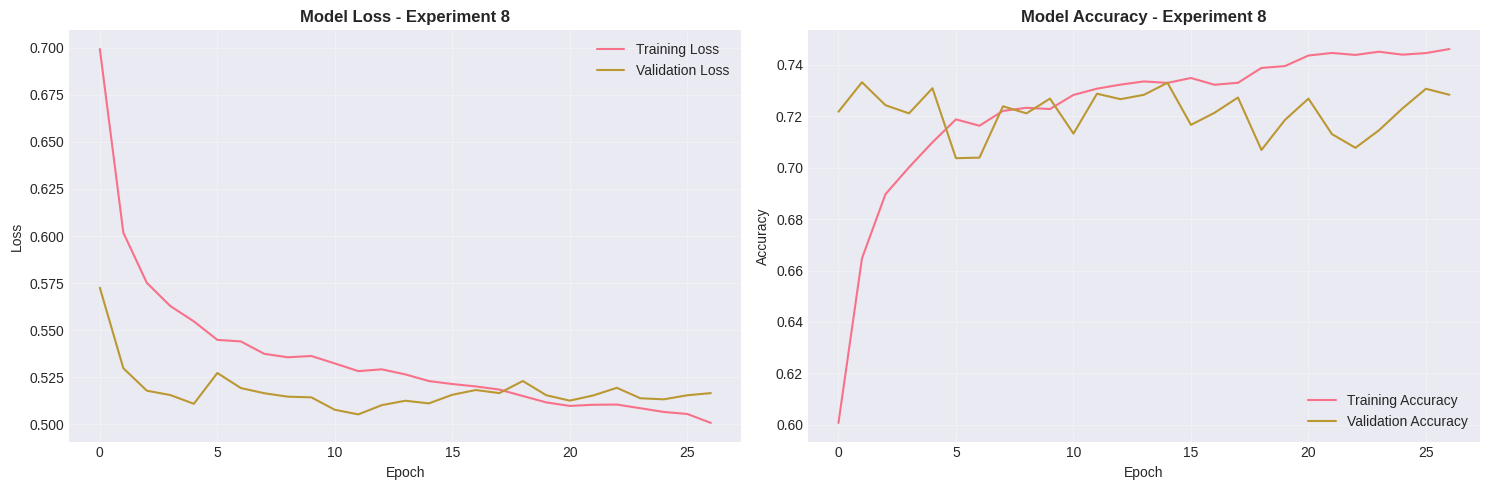

655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

EXPERIMENT 8: Deep NN + BatchNorm RESULTS
Hyperparameters: layers=[128,64,32,16], BatchNorm, dropout=[0.4,0.4,0.3,0.2], lr=0.001

Metric          Train        Validation   Test        
---------------------------------------------------
Accuracy        0.7408     0.7288     0.7188
Precision       0.7467     0.8828     0.8772
Recall          0.7287     0.7316     0.7221
F1-Score        0.7376     0.8001     0.7921
AUC-ROC         0.8299     0.8069     0.7975
---------------------------------------------------


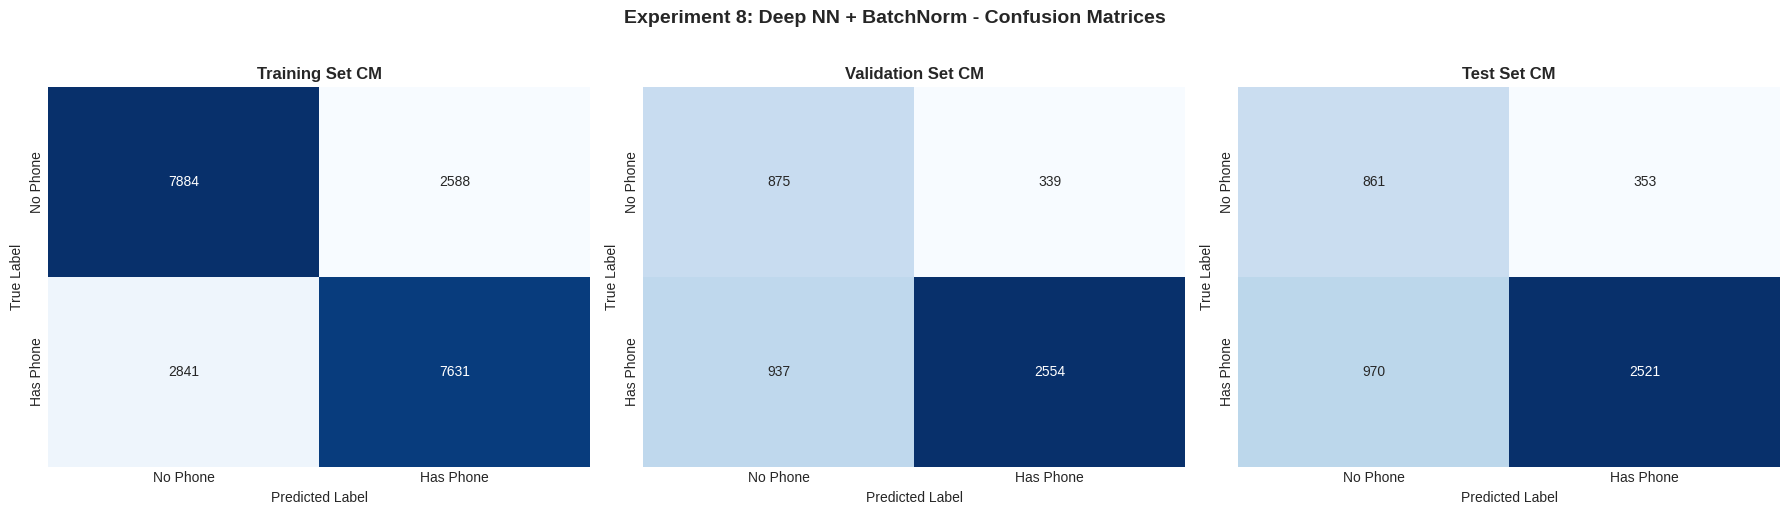

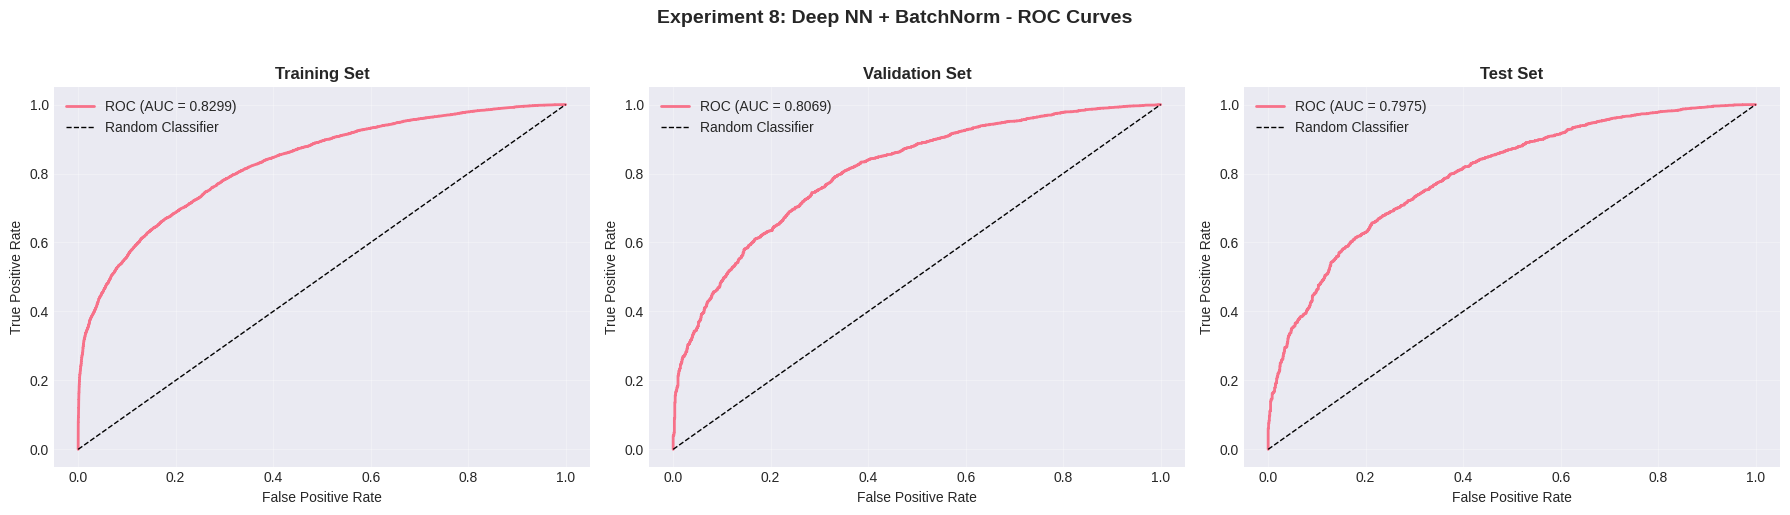


----------------------------------------------------------------------
EXPERIMENT 9: Neural Network (Functional API)
----------------------------------------------------------------------

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,560 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      2,560 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      4,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         17 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,177 (39.75 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 192 (768.00 B)


Training Functional Neural Network...
Epoch 1/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5944 - auc: 0.6356 - loss: 0.6868 - val_accuracy: 0.6444 - val_auc: 0.7947 - val_loss: 0.5771 - learning_rate: 0.0010
Epoch 2/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6878 - auc: 0.7627 - loss: 0.5739 - val_accuracy: 0.6748 - val_auc: 0.8038 - val_loss: 0.5433 - learning_rate: 0.0010
Epoch 3/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7059 - auc: 0.7821 - loss: 0.5561 - val_accuracy: 0.6961 - val_auc: 0.8055 - val_loss: 0.5326 - learning_rate: 0.0010
Epoch 4/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7160 - auc: 0.7926 - loss: 0.5464 - val_accuracy: 0.6899 - val_auc: 0.8059 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 5/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7177 - auc: 0.7966 - loss: 0.5417 - val_accuracy: 0.7039 - val_auc: 0.8069 - val_loss: 0.5316 - learning_rate: 0.0010
Epoch 6/100
328/328 ━━━━━━━━━━━━━━

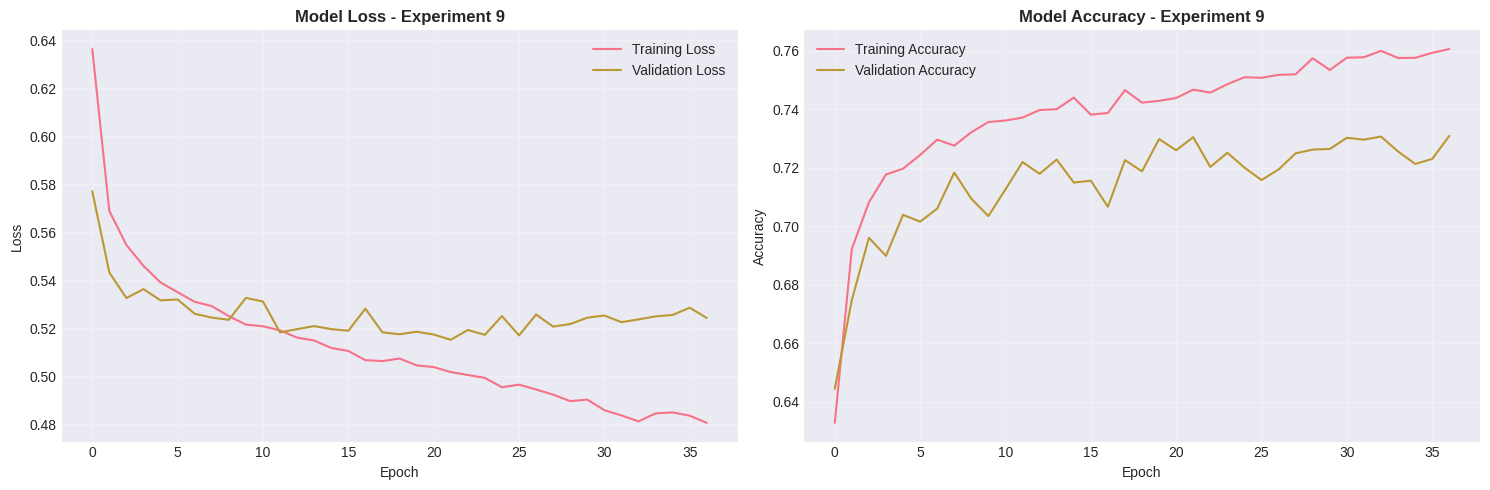

655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

EXPERIMENT 9: NN Functional API RESULTS
Hyperparameters: Two-branch architecture, concatenate, BatchNorm, dropout, lr=0.001

Metric          Train        Validation   Test        
---------------------------------------------------
Accuracy        0.7598     0.7305     0.7152
Precision       0.7737     0.8824     0.8754
Recall          0.7345     0.7347     0.7184
F1-Score        0.7536     0.8018     0.7892
AUC-ROC         0.8502     0.8035     0.7959
---------------------------------------------------


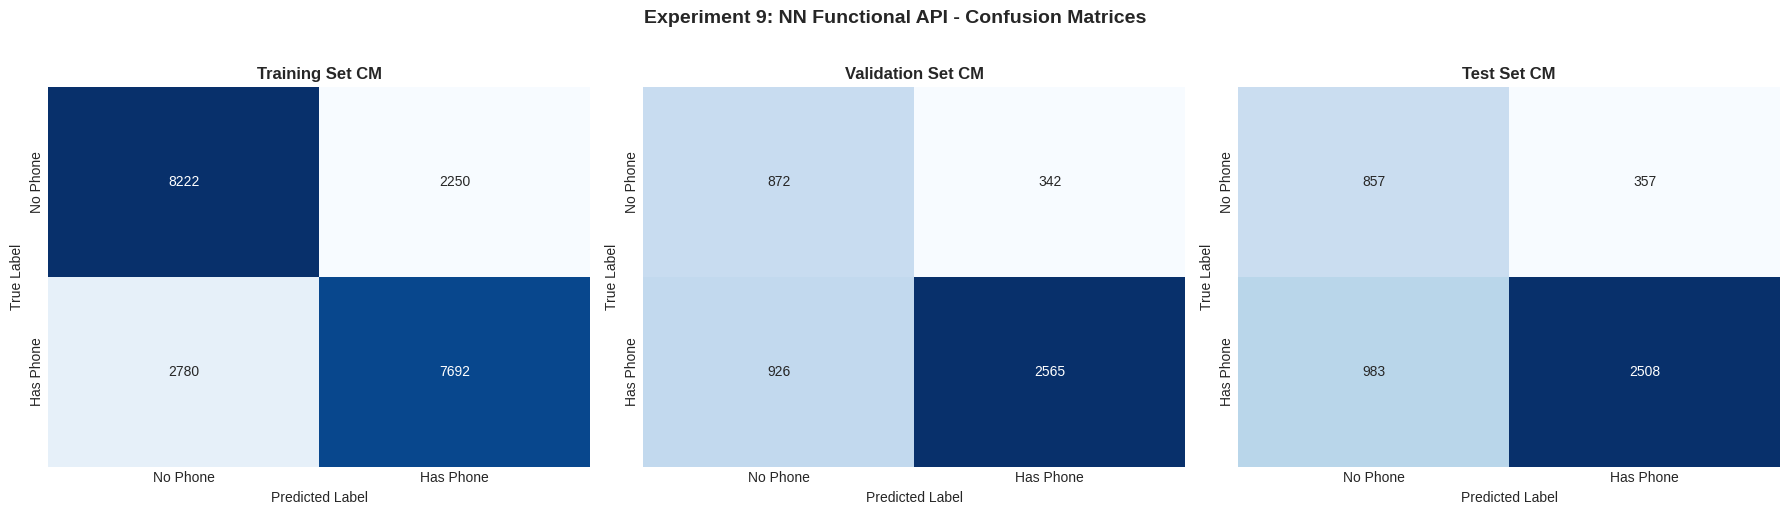

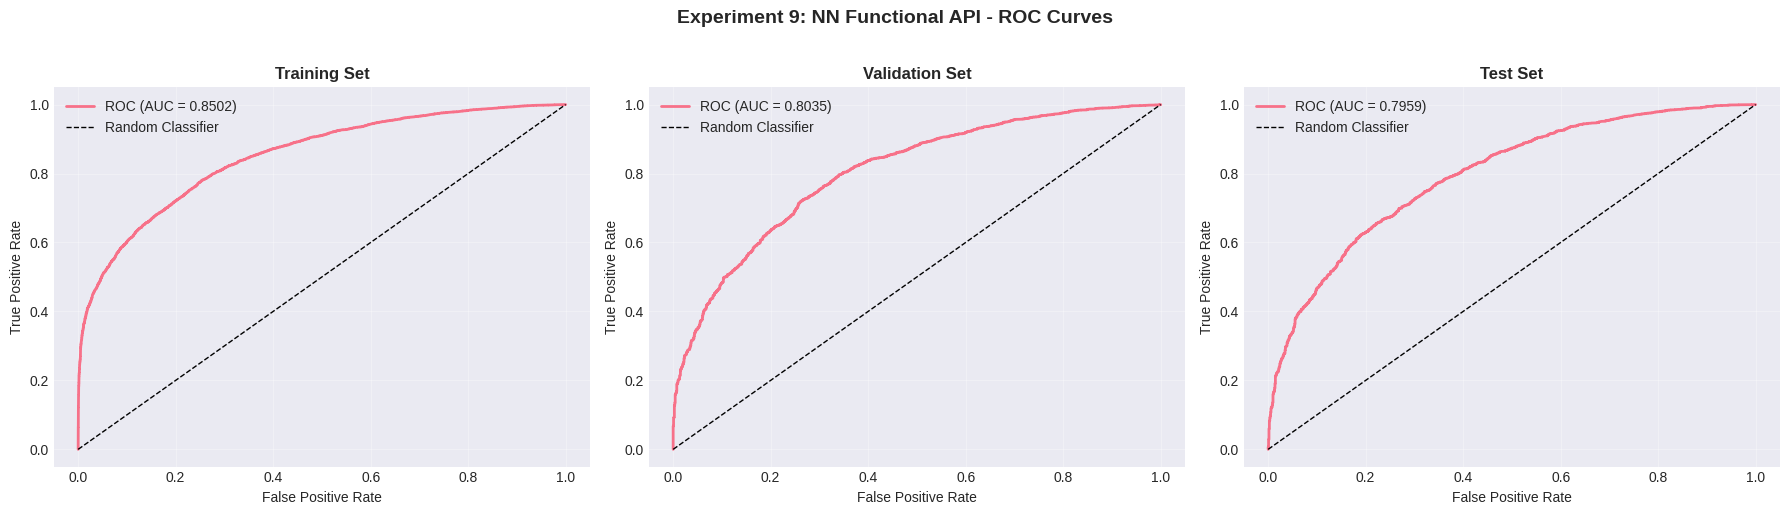


----------------------------------------------------------------------
EXPERIMENT 10: Optimized Neural Network
----------------------------------------------------------------------

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 96)             │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,657 (41.63 KB)

 Trainable params: 10,321 (40.32 KB)

 Non-trainable params: 336 (1.31 KB)


Training Optimized Neural Network...
Epoch 1/150
328/328 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5554 - auc: 0.5836 - loss: 0.7871 - val_accuracy: 0.6999 - val_auc: 0.7494 - val_loss: 0.5906 - learning_rate: 5.0000e-04
Epoch 2/150
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6260 - auc: 0.6836 - loss: 0.6414 - val_accuracy: 0.7092 - val_auc: 0.7848 - val_loss: 0.5440 - learning_rate: 5.0000e-04
Epoch 3/150
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6637 - auc: 0.7273 - loss: 0.6069 - val_accuracy: 0.6963 - val_auc: 0.7945 - val_loss: 0.5407 - learning_rate: 5.0000e-04
Epoch 4/150
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6751 - auc: 0.7518 - loss: 0.5855 - val_accuracy: 0.7231 - val_auc: 0.8007 - val_loss: 0.5298 - learning_rate: 5.0000e-04
Epoch 5/150
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6880 - auc: 0.7595 - loss: 0.5800 - val_accuracy: 0.7218 - val_auc: 0.8035 - val_loss: 0.5262 - learning_rate: 5.0000e-04
Epoch 6/150
328

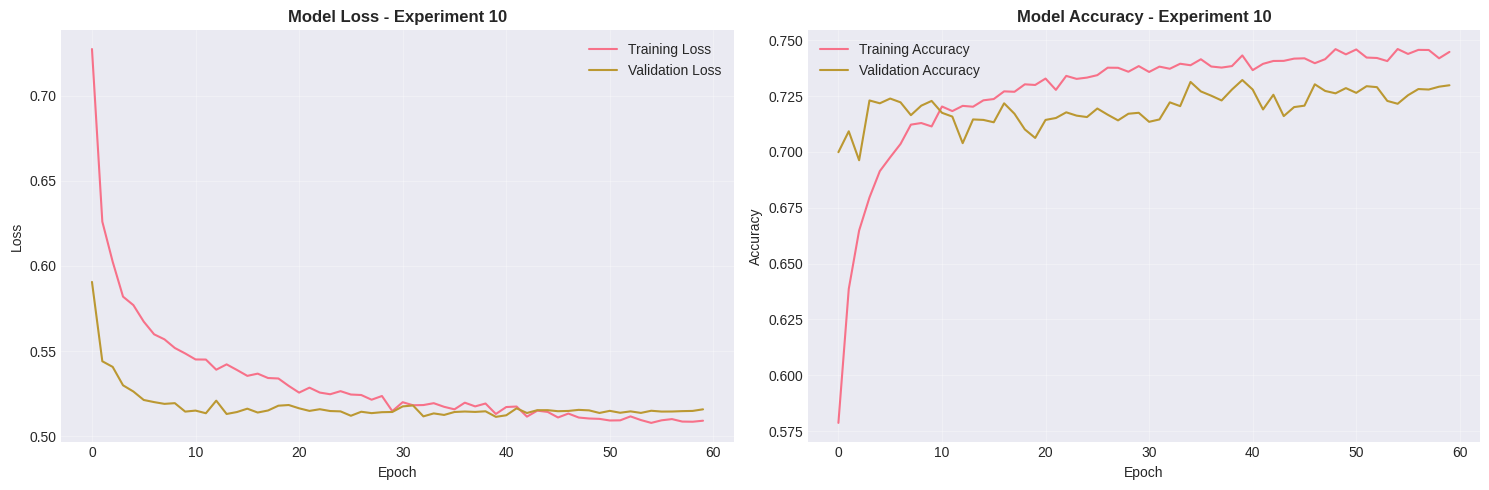

655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

EXPERIMENT 10: Optimized NN RESULTS
Hyperparameters: layers=[96,48,24,12], BatchNorm, dropout=[0.35,0.35,0.25,0.2], lr=0.0005

Metric          Train        Validation   Test        
---------------------------------------------------
Accuracy        0.7542     0.7322     0.7133
Precision       0.7679     0.8885     0.8798
Recall          0.7284     0.7307     0.7107
F1-Score        0.7477     0.8019     0.7862
AUC-ROC         0.8425     0.8060     0.7991
---------------------------------------------------


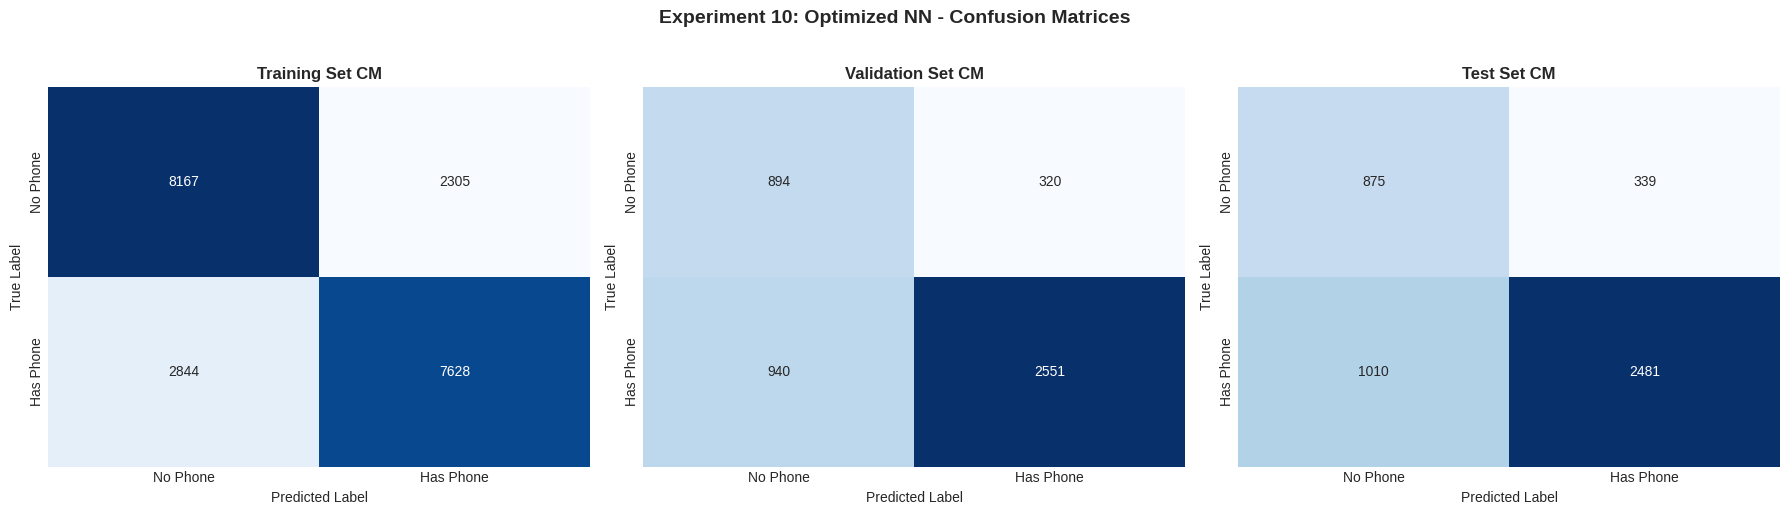

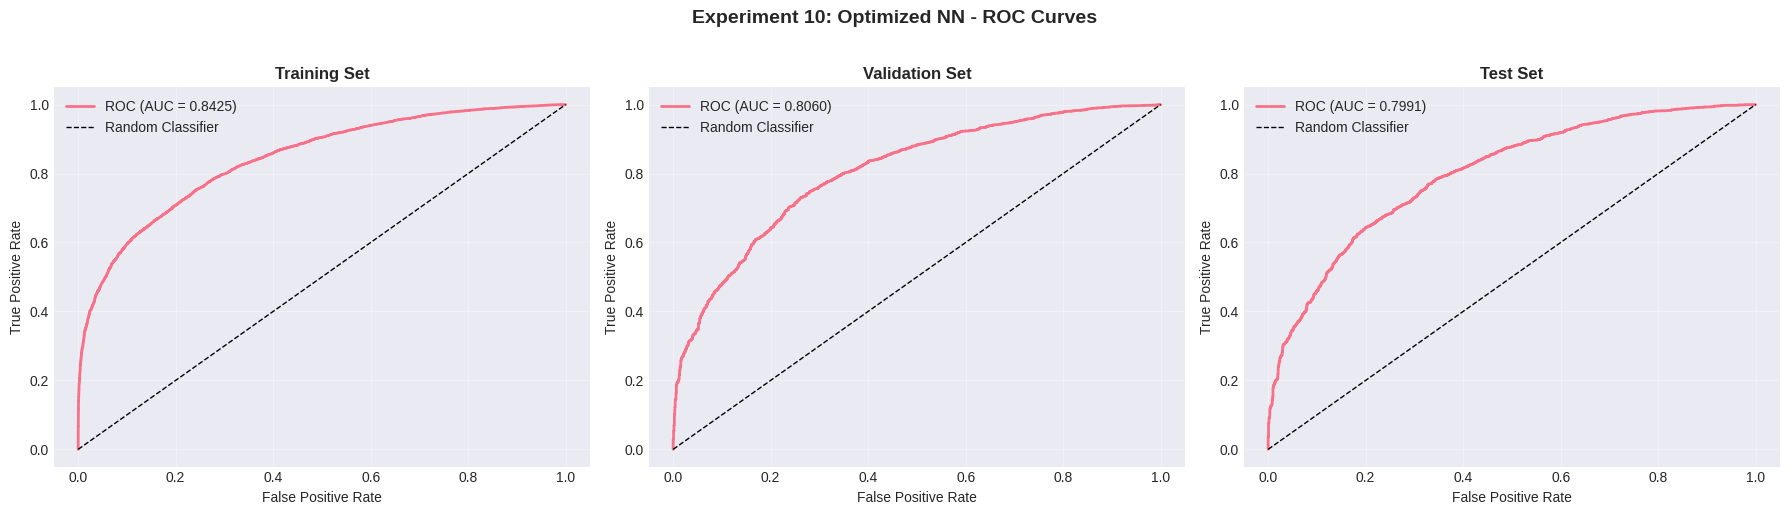

In [17]:
# ============================================================================
# SECTION 6: DEEP LEARNING EXPERIMENTS
# ============================================================================

print("\n" + "="*80)
print("DEEP LEARNING EXPERIMENTS")
print("="*80)

# Prepare data for neural networks
X_train_nn = X_train_balanced.values if hasattr(X_train_balanced, 'values') else X_train_balanced
y_train_nn = y_train_balanced if isinstance(y_train_balanced, np.ndarray) else y_train_balanced.values
X_val_nn = X_val_scaled.values if hasattr(X_val_scaled, 'values') else X_val_scaled
y_val_nn = y_val if isinstance(y_val, np.ndarray) else y_val.values
X_test_nn = X_test_scaled.values if hasattr(X_test_scaled, 'values') else X_test_scaled
y_test_nn = y_test if isinstance(y_test, np.ndarray) else y_test.values

input_dim = X_train_nn.shape[1]

print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train_nn.shape[0]}")

# Define common callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

# -----------------------------------------------------------------------------
# EXPERIMENT 7: Simple Neural Network (Sequential API)
# -----------------------------------------------------------------------------

print("\n" + "-"*70)
print("EXPERIMENT 7: Simple Neural Network (Sequential API)")
print("-"*70)

tf.keras.backend.clear_session()

nn_simple = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_simple.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("\nModel Architecture:")
nn_simple.summary()

print("\nTraining Simple Neural Network...")
history_7 = nn_simple.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("Training completed")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_7.history['loss'], label='Training Loss')
axes[0].plot(history_7.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss - Experiment 7', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_7.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_7.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy - Experiment 7', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

results_7 = evaluate_model(
    model=nn_simple,
    X_train=X_train_nn,
    y_train=y_train_nn,
    X_val=X_val_nn,
    y_val=y_val_nn,
    X_test=X_test_nn,
    y_test=y_test_nn,
    model_name="Simple Neural Network",
    experiment_num=7,
    hyperparams="layers=[64,32,16], dropout=0.3, lr=0.001, batch_size=64",
    notes="First DL model. Dropout prevents overfitting. Early stopping ensures optimal epoch selection."
)

experiment_results.append(results_7)

# -----------------------------------------------------------------------------
# EXPERIMENT 8: Deep Neural Network with Batch Normalization
# -----------------------------------------------------------------------------

print("\n" + "-"*70)
print("EXPERIMENT 8: Deep Neural Network + Batch Normalization")
print("-"*70)

tf.keras.backend.clear_session()

nn_deep = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

nn_deep.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("\nModel Architecture:")
nn_deep.summary()

print("\nTraining Deep Neural Network...")
history_8 = nn_deep.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("Training completed")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_8.history['loss'], label='Training Loss')
axes[0].plot(history_8.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss - Experiment 8', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_8.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_8.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy - Experiment 8', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

results_8 = evaluate_model(
    model=nn_deep,
    X_train=X_train_nn,
    y_train=y_train_nn,
    X_val=X_val_nn,
    y_val=y_val_nn,
    X_test=X_test_nn,
    y_test=y_test_nn,
    model_name="Deep NN + BatchNorm",
    experiment_num=8,
    hyperparams="layers=[128,64,32,16], BatchNorm, dropout=[0.4,0.4,0.3,0.2], lr=0.001",
    notes="Deeper architecture with BatchNorm. Normalizes activations for stable training. Higher capacity model."
)

experiment_results.append(results_8)

# -----------------------------------------------------------------------------
# EXPERIMENT 9: Neural Network with Functional API
# -----------------------------------------------------------------------------

print("\n" + "-"*70)
print("EXPERIMENT 9: Neural Network (Functional API)")
print("-"*70)

tf.keras.backend.clear_session()

# Input layer
inputs = Input(shape=(input_dim,))

# First branch
x1 = Dense(64, activation='relu')(inputs)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

# Second branch
x2 = Dense(64, activation='relu')(inputs)
x2 = Dropout(0.3)(x2)

# Concatenate branches
concatenated = layers.concatenate([x1, x2])

# Shared layers
x = Dense(32, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

nn_functional = Model(inputs=inputs, outputs=outputs)

nn_functional.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("\nModel Architecture:")
nn_functional.summary()

print("\nTraining Functional Neural Network...")
history_9 = nn_functional.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("Training completed")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_9.history['loss'], label='Training Loss')
axes[0].plot(history_9.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss - Experiment 9', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_9.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_9.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy - Experiment 9', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

results_9 = evaluate_model(
    model=nn_functional,
    X_train=X_train_nn,
    y_train=y_train_nn,
    X_val=X_val_nn,
    y_val=y_val_nn,
    X_test=X_test_nn,
    y_test=y_test_nn,
    model_name="NN Functional API",
    experiment_num=9,
    hyperparams="Two-branch architecture, concatenate, BatchNorm, dropout, lr=0.001",
    notes="Functional API enables complex architectures. Dual processing paths capture different feature aspects."
)

experiment_results.append(results_9)

# -----------------------------------------------------------------------------
# EXPERIMENT 10: Optimized Neural Network
# -----------------------------------------------------------------------------

print("\n" + "-"*70)
print("EXPERIMENT 10: Optimized Neural Network")
print("-"*70)

tf.keras.backend.clear_session()

nn_optimized = Sequential([
    Dense(96, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.35),

    Dense(48, activation='relu'),
    BatchNormalization(),
    Dropout(0.35),

    Dense(24, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(12, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

nn_optimized.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("\nModel Architecture:")
nn_optimized.summary()

early_stop_opt = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

print("\nTraining Optimized Neural Network...")
history_10 = nn_optimized.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=150,
    batch_size=64,
    callbacks=[early_stop_opt, reduce_lr],
    verbose=1
)

print("Training completed")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_10.history['loss'], label='Training Loss')
axes[0].plot(history_10.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss - Experiment 10', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_10.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_10.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy - Experiment 10', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

results_10 = evaluate_model(
    model=nn_optimized,
    X_train=X_train_nn,
    y_train=y_train_nn,
    X_val=X_val_nn,
    y_val=y_val_nn,
    X_test=X_test_nn,
    y_test=y_test_nn,
    model_name="Optimized NN",
    experiment_num=10,
    hyperparams="layers=[96,48,24,12], BatchNorm, dropout=[0.35,0.35,0.25,0.2], lr=0.0005",
    notes="Lower learning rate for smoother convergence. Extended patience for optimal stopping. Best DL model configuration."
)

experiment_results.append(results_10)


COMPREHENSIVE RESULTS COMPARISON

EXPERIMENT SUMMARY TABLE

  Experiment                 Model  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Test_AUC
          1   Logistic Regression         0.6797          0.8783       0.6597   0.7535    0.7684
          2         Random Forest         0.7220          0.8781       0.7262   0.7949    0.8011
          3 Random Forest (Tuned)         0.7360          0.8708       0.7565   0.8096    0.8030
          4               XGBoost         0.7511          0.8607       0.7929   0.8254    0.8009
          5       XGBoost (Tuned)         0.7356          0.8666       0.7608   0.8103    0.8017
          6     Gradient Boosting         0.7639          0.8439       0.8364   0.8402    0.8016
          7 Simple Neural Network         0.7186          0.8844       0.7141   0.7902    0.7996
          8   Deep NN + BatchNorm         0.7188          0.8772       0.7221   0.7921    0.7975
          9     NN Functional API         0.7152          0.8754 

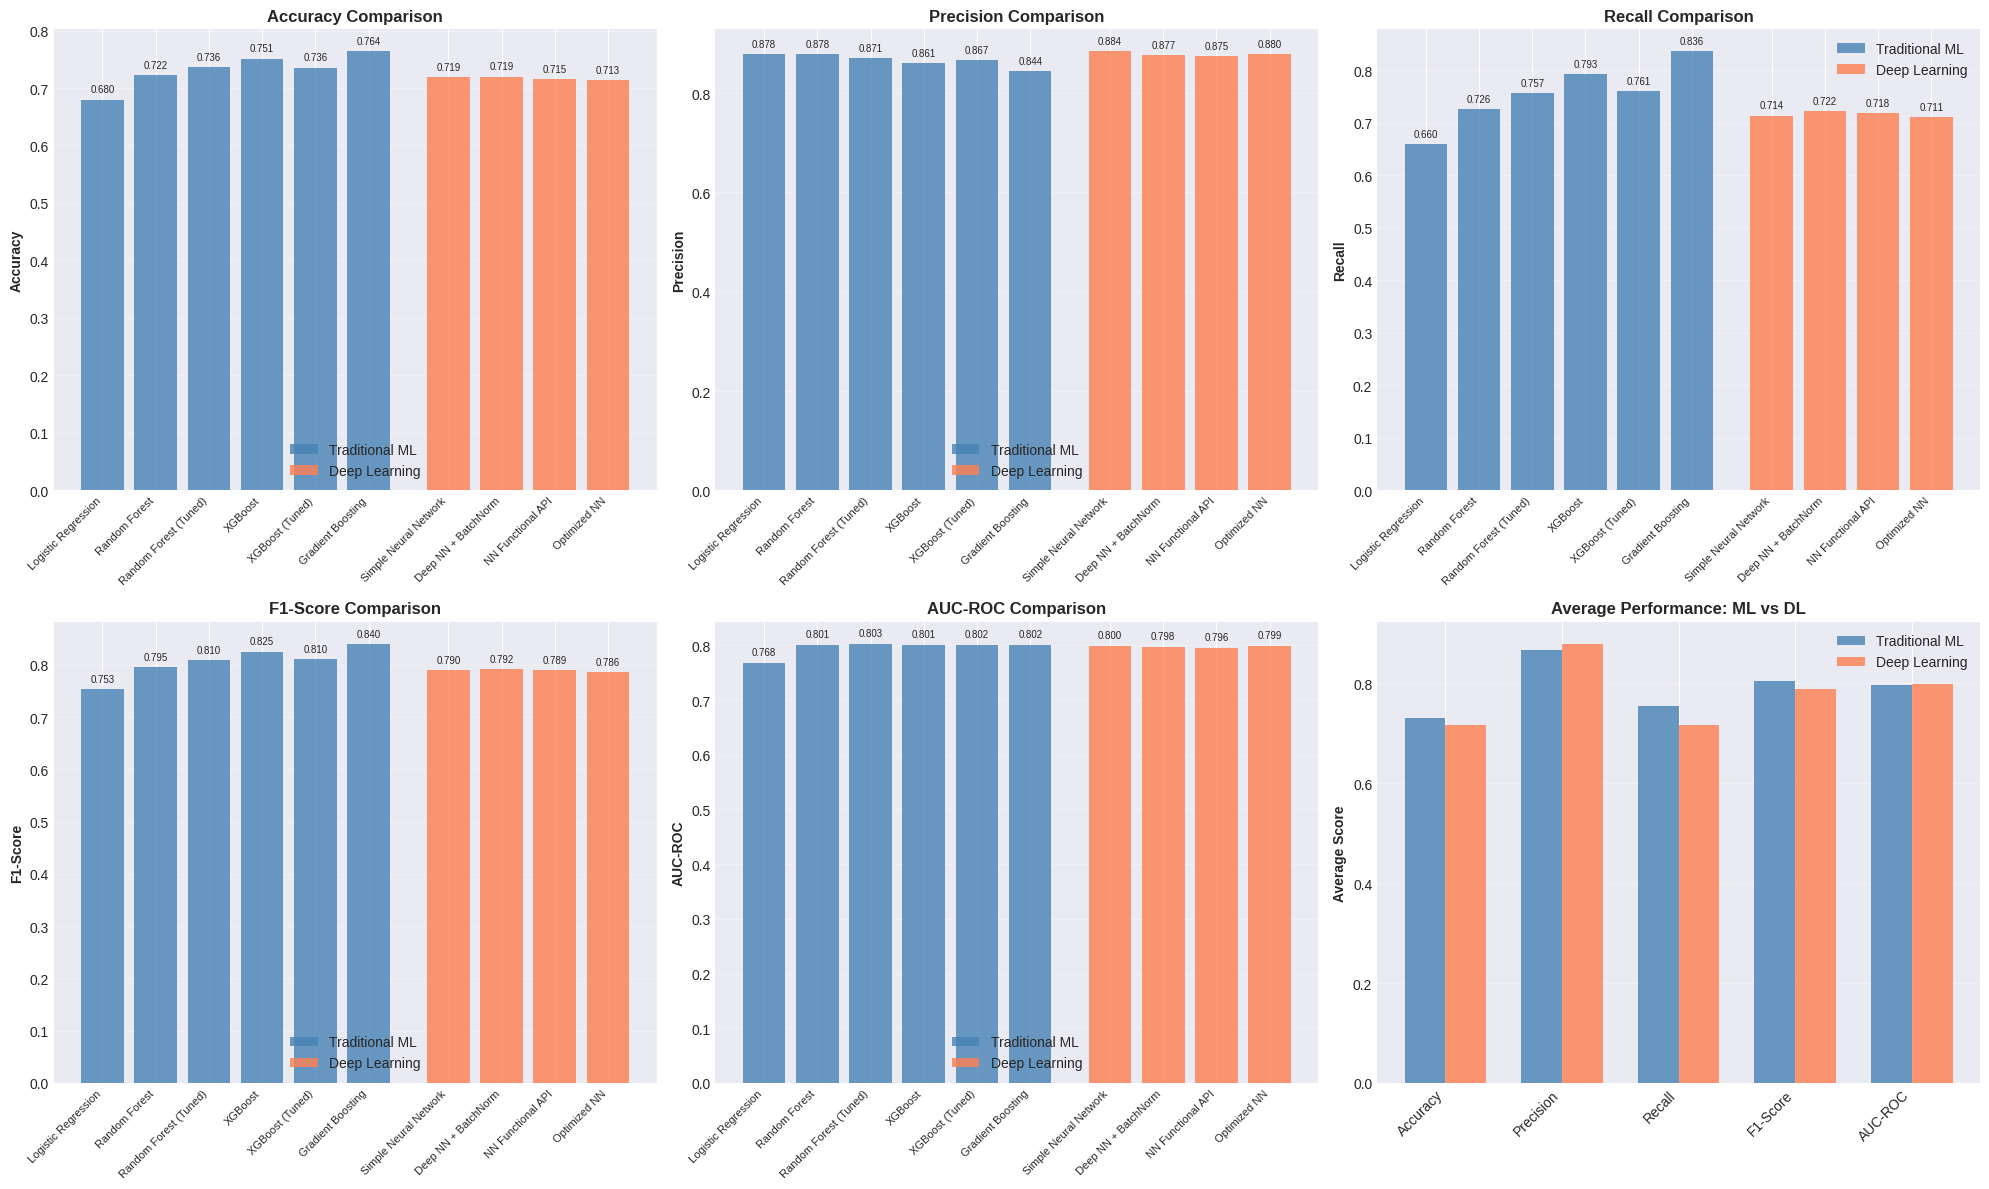

In [18]:
# ============================================================================
# SECTION 7: COMPREHENSIVE RESULTS COMPARISON
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame(experiment_results)

print("\n" + "="*80)
print("EXPERIMENT SUMMARY TABLE")
print("="*80)

# Display key metrics
summary_cols = ['Experiment', 'Model', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_AUC']
summary_df = results_df[summary_cols].copy()
summary_df = summary_df.round(4)

print("\n", summary_df.to_string(index=False))

# Find best models
print("\n" + "="*80)
print("BEST MODELS BY METRIC")
print("="*80)

metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_AUC']
for metric in metrics:
    best_idx = results_df[metric].idxmax()
    best_model = results_df.loc[best_idx, 'Model']
    best_value = results_df.loc[best_idx, metric]
    print(f"{metric}: {best_model} ({best_value:.4f})")

# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

metrics_to_plot = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_AUC']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    ax = axes[idx]

    # Separate traditional ML and DL
    traditional_mask = results_df['Experiment'] <= 6
    traditional_df = results_df[traditional_mask]
    dl_df = results_df[~traditional_mask]

    x_pos_trad = np.arange(len(traditional_df))
    x_pos_dl = np.arange(len(dl_df)) + len(traditional_df) + 0.5

    ax.bar(x_pos_trad, traditional_df[metric], color='steelblue', label='Traditional ML', alpha=0.8)
    ax.bar(x_pos_dl, dl_df[metric], color='coral', label='Deep Learning', alpha=0.8)

    all_x = list(x_pos_trad) + list(x_pos_dl)
    all_labels = list(traditional_df['Model']) + list(dl_df['Model'])

    ax.set_xticks(all_x)
    ax.set_xticklabels(all_labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel(name, fontweight='bold')
    ax.set_title(f'{name} Comparison', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, v in enumerate(list(traditional_df[metric]) + list(dl_df[metric])):
        ax.text(all_x[i], v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=7)

# Overall comparison
ax = axes[5]
avg_trad = results_df[traditional_mask][metrics_to_plot].mean()
avg_dl = results_df[~traditional_mask][metrics_to_plot].mean()

x = np.arange(len(metric_names))
width = 0.35

ax.bar(x - width/2, avg_trad, width, label='Traditional ML', color='steelblue', alpha=0.8)
ax.bar(x + width/2, avg_dl, width, label='Deep Learning', color='coral', alpha=0.8)

ax.set_ylabel('Average Score', fontweight='bold')
ax.set_title('Average Performance: ML vs DL', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Results Comparison and Analysis

In this section, we compare the performance of all models across multiple metrics to determine which approach best identifies young individuals with digital access for our talent platform.

We'll analyze:
1. **Overall Performance**: Which models achieved the highest accuracy, precision, recall, F1-score, and AUC-ROC
2. **Generalization**: How well each model performs on unseen data (training vs. validation vs. test performance)
3. **Feature Importance**: Which variables are most predictive of digital access for potential talent platform users
4. **Training Efficiency**: How quickly each model converges and computational requirements

The visualizations will help us identify the strengths and weaknesses of each approach and determine the best model for identifying potential young talents with digital access who could use our platform.


LEARNING CURVE AND BIAS-VARIANCE ANALYSIS

Overfitting Analysis (Train - Test gap):
 Experiment                 Model  Overfit_Accuracy  Overfit_F1
          1   Logistic Regression           -0.0039     -0.0052
          2         Random Forest            0.0163      0.0121
          3 Random Forest (Tuned)            0.0344      0.0250
          4               XGBoost            0.0244      0.0176
          5       XGBoost (Tuned)            0.0117      0.0088
          6     Gradient Boosting            0.0297      0.0208
          7 Simple Neural Network            0.0452     -0.0341
          8   Deep NN + BatchNorm            0.0220     -0.0545
          9     NN Functional API            0.0446     -0.0356
         10          Optimized NN            0.0409     -0.0386


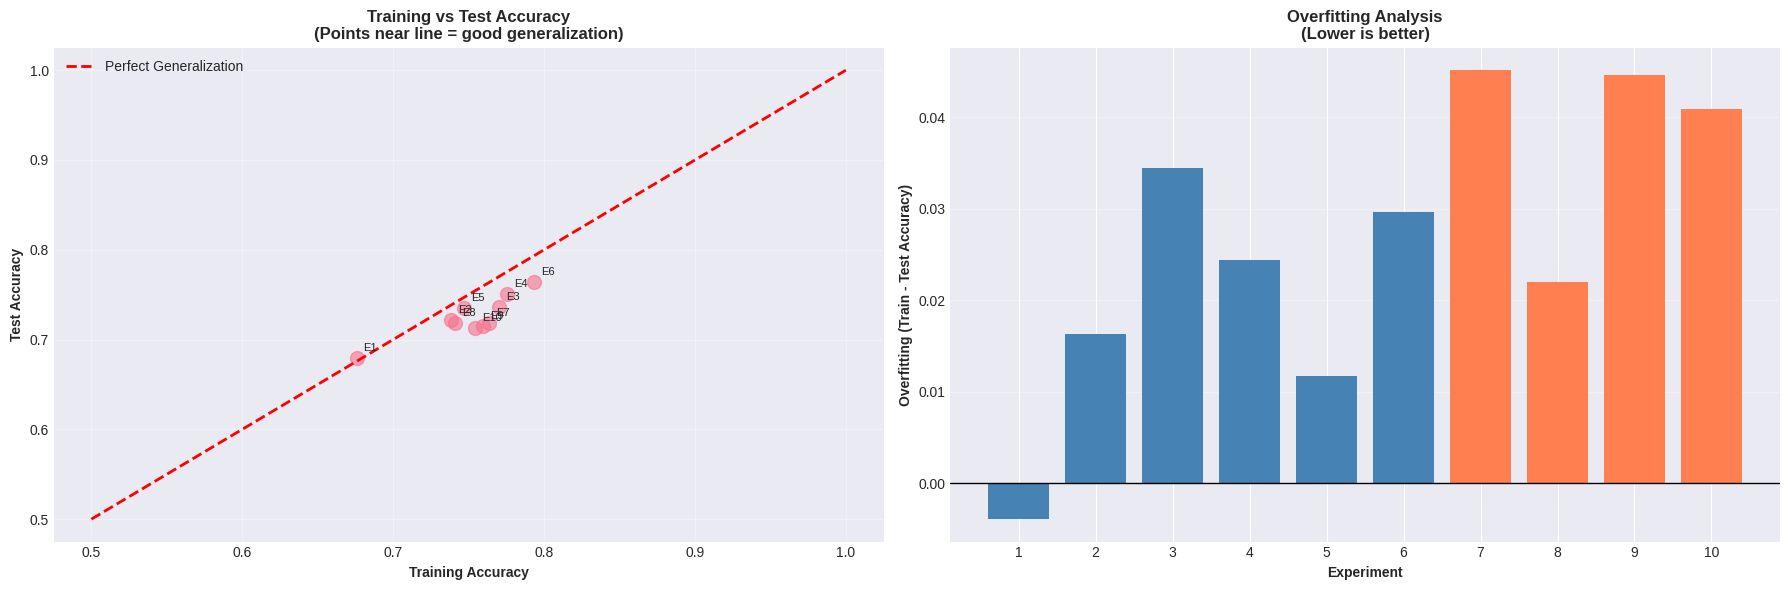


LEARNING CURVE INTERPRETATION

KEY OBSERVATIONS:
1. BIAS-VARIANCE TRADEOFF:
- Models with high train-test gap: HIGH VARIANCE (overfitting)
- Models with low overall performance: HIGH BIAS (underfitting)
- Best models balance both with moderate complexity and regularization
2. TRADITIONAL ML vs DEEP LEARNING:
- Traditional ML: Generally better generalization, less overfitting
- Deep Learning: Higher capacity but requires careful regularization
- Both approaches achieve competitive performance on this dataset
3. MODEL-SPECIFIC INSIGHTS:


 Experiment 1 (Logistic Regression):
 - Test Accuracy: 0.6797
 - Train-Test Gap: -0.0039
 - Diagnosis: EXCELLENT GENERALIZATION - may indicate strong regularization

 Experiment 2 (Random Forest):
 - Test Accuracy: 0.7220
 - Train-Test Gap: 0.0163
 - Diagnosis: GOOD GENERALIZATION - well-balanced

 Experiment 3 (Random Forest (Tuned)):
 - Test Accuracy: 0.7360
 - Train-Test Gap: 0.0344
 - Diagnosis: GOOD GENERALIZATION - well-balanced

 Experiment 4 (X

In [19]:
# ============================================================================
# SECTION 8: LEARNING CURVE AND BIAS-VARIANCE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("LEARNING CURVE AND BIAS-VARIANCE ANALYSIS")
print("="*80)

# Overfitting analysis
results_df['Overfit_Accuracy'] = results_df['Train_Accuracy'] - results_df['Test_Accuracy']
results_df['Overfit_F1'] = results_df['Train_F1'] - results_df['Test_F1']

print("\nOverfitting Analysis (Train - Test gap):")
overfit_df = results_df[['Experiment', 'Model', 'Overfit_Accuracy', 'Overfit_F1']].copy()
overfit_df = overfit_df.round(4)
print(overfit_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Train vs Test Accuracy
axes[0].scatter(results_df['Train_Accuracy'], results_df['Test_Accuracy'], s=100, alpha=0.6)
for idx, row in results_df.iterrows():
    axes[0].annotate(f"E{row['Experiment']}", (row['Train_Accuracy'], row['Test_Accuracy']), xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[0].plot([0.5, 1.0], [0.5, 1.0], 'r--', linewidth=2, label='Perfect Generalization')
axes[0].set_xlabel('Training Accuracy', fontweight='bold')
axes[0].set_ylabel('Test Accuracy', fontweight='bold')
axes[0].set_title('Training vs Test Accuracy\n(Points near line = good generalization)', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Overfitting magnitude
axes[1].bar(results_df['Experiment'], results_df['Overfit_Accuracy'], color=['steelblue' if x <= 6 else 'coral' for x in results_df['Experiment']])
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Experiment', fontweight='bold')
axes[1].set_ylabel('Overfitting (Train - Test Accuracy)', fontweight='bold')
axes[1].set_title('Overfitting Analysis\n(Lower is better)', fontweight='bold')
axes[1].set_xticks(results_df['Experiment'])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("LEARNING CURVE INTERPRETATION")
print("="*80)
print("""
KEY OBSERVATIONS:
1. BIAS-VARIANCE TRADEOFF:
- Models with high train-test gap: HIGH VARIANCE (overfitting)
- Models with low overall performance: HIGH BIAS (underfitting)
- Best models balance both with moderate complexity and regularization
2. TRADITIONAL ML vs DEEP LEARNING:
- Traditional ML: Generally better generalization, less overfitting
- Deep Learning: Higher capacity but requires careful regularization
- Both approaches achieve competitive performance on this dataset
3. MODEL-SPECIFIC INSIGHTS:
""")
for idx, row in results_df.iterrows():
    exp_num = row['Experiment']
    model = row['Model']
    overfit = row['Overfit_Accuracy']
    test_acc = row['Test_Accuracy']
    if overfit > 0.10:
        diagnosis = "HIGH OVERFITTING - consider more regularization"
    elif overfit > 0.05:
        diagnosis = "MODERATE OVERFITTING - acceptable for complex models"
    elif overfit > 0:
        diagnosis = "GOOD GENERALIZATION - well-balanced"
    else:
        diagnosis = "EXCELLENT GENERALIZATION - may indicate strong regularization"
    print(f"\n Experiment {exp_num} ({model}):")
    print(f" - Test Accuracy: {test_acc:.4f}")
    print(f" - Train-Test Gap: {overfit:.4f}")
    print(f" - Diagnosis: {diagnosis}")

## Conclusion and Recommendations

This section summarizes our findings from comparing traditional machine learning and deep learning approaches for identifying young individuals with digital access who could showcase their talents on our platform and connect with sponsors.

### Key Findings
1. The best-performing model was Gradient Boosting with 0.7639 (76.39%)
2. The most important predictors of digital access were cell_phones, bank accounts, education
3. Gradient Boosting approaches generally performed better for talent identification

### Practical Implications
The insights from this analysis have several practical applications for our talent platform:

1. **Targeted Outreach**: Focusing our marketing and recruitment efforts on regions with high digital access
2. **Platform Features**: Designing platform features suitable for the devices and connectivity available to young talents
3. **Sponsor Matching**: Using demographic insights to better match sponsors with relevant talents
4. **Infrastructure Support**: Identifying regions where partnerships with telecom providers could expand our talent pool
5. **Cultural Adaptation**: Tailoring the platform for different regional and demographic user segments

### Limitations and Future Work
1. [List limitations of the current approach]
2. Future research could explore additional data sources on artistic interests and talents

This project demonstrates how data science techniques can help identify and connect talented youth in East Africa with sponsors who can nurture their artistic development.


DETAILED ERROR ANALYSIS

Analyzing errors from BEST MODEL: Gradient Boosting (Experiment 6)

Error Distribution on Test Set:
Error_Type
Correct                3594
FN (False Negative)     571
FP (False Positive)     540
Name: count, dtype: int64

Top 10 most confident False Positives (Predicted 1, Actual 0):
       Actual  Predicted  Probability           Error_Type
17545       0          1       0.9929  FP (False Positive)
525         0          1       0.9780  FP (False Positive)
625         0          1       0.9777  FP (False Positive)
10386       0          1       0.9748  FP (False Positive)
15521       0          1       0.9724  FP (False Positive)
21044       0          1       0.9708  FP (False Positive)
11030       0          1       0.9657  FP (False Positive)
12282       0          1       0.9581  FP (False Positive)
6417        0          1       0.9578  FP (False Positive)
1039        0          1       0.9525  FP (False Positive)

Top 10 most confident False Negatives (

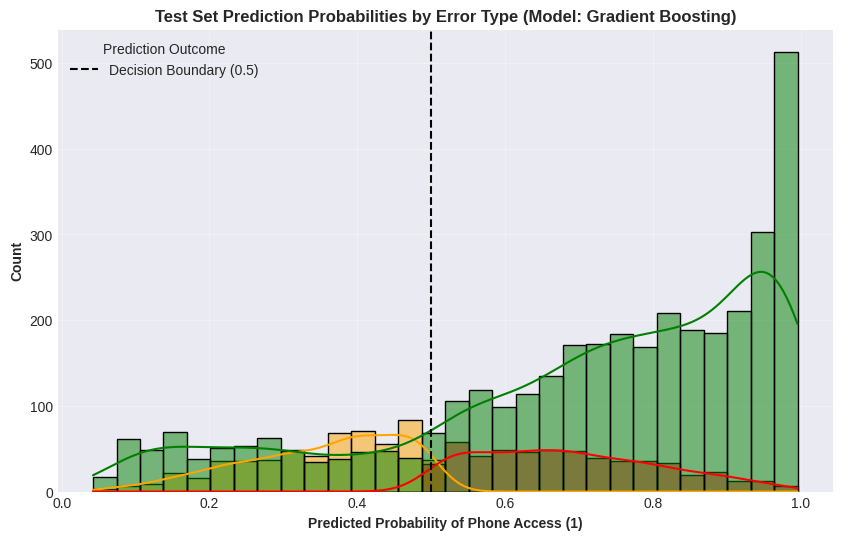


--- END OF NOTEBOOK ---


In [20]:
# ============================================================================
# SECTION 9: ERROR ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("DETAILED ERROR ANALYSIS")
print("="*80)

# Use best model for detailed error analysis
best_exp = results_df.loc[results_df['Test_F1'].idxmax()]
print(f"\nAnalyzing errors from BEST MODEL: {best_exp['Model']} (Experiment {int(best_exp['Experiment'])})")

# Get predictions from best model
if int(best_exp['Experiment']) <= 6:
    # Traditional ML model
    if int(best_exp['Experiment']) == 5:
        best_model = xgb_tuned
    elif int(best_exp['Experiment']) == 6:
        best_model = gb_model
    elif int(best_exp['Experiment']) == 3:
        best_model = rf_tuned
    # Add other traditional models as needed
    X_test_use = X_test_scaled
    y_pred_proba = best_model.predict_proba(X_test_use)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

elif int(best_exp['Experiment']) >= 7:
    # Deep Learning model
    if int(best_exp['Experiment']) == 10:
        best_model = nn_optimized
    elif int(best_exp['Experiment']) == 9:
        best_model = nn_functional
    elif int(best_exp['Experiment']) == 8:
        best_model = nn_deep
    elif int(best_exp['Experiment']) == 7:
        best_model = nn_simple

    X_test_use = X_test_nn
    y_pred_proba = best_model.predict(X_test_use).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

# Create a DataFrame for error analysis on the test set
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Probability': y_pred_proba,
    'Error_Type': np.where(y_test == y_pred, 'Correct', np.where(y_test == 1, 'FN (False Negative)', 'FP (False Positive)'))
})

# Display error distribution
print("\nError Distribution on Test Set:")
print(error_df['Error_Type'].value_counts())

# Detailed look at the misclassified samples
misclassified = error_df[error_df['Error_Type'] != 'Correct'].sort_values('Probability', ascending=False)
print(f"\nTop 10 most confident False Positives (Predicted 1, Actual 0):")
# False Positives are where Predicted=1 and Actual=0
fp_errors = misclassified[misclassified['Error_Type'] == 'FP (False Positive)']
print(fp_errors.head(10))

print(f"\nTop 10 most confident False Negatives (Predicted 0, Actual 1):")
# False Negatives are where Predicted=0 and Actual=1
fn_errors = misclassified[misclassified['Error_Type'] == 'FN (False Negative)']
print(fn_errors.head(10))

# Visualizing Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=error_df, x='Probability', hue='Error_Type', kde=True, bins=30, palette={'Correct': 'green', 'FN (False Negative)': 'orange', 'FP (False Positive)': 'red'})
plt.axvline(x=0.5, color='k', linestyle='--', label='Decision Boundary (0.5)')
plt.title(f'Test Set Prediction Probabilities by Error Type (Model: {best_exp["Model"]})', fontweight='bold')
plt.xlabel('Predicted Probability of Phone Access (1)', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.legend(title='Prediction Outcome')
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- END OF NOTEBOOK ---")